In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

def load_data_from_npy_files(data_dir):
    X, y = [], []
    
    for file_name in os.listdir(data_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(data_dir, file_name)
            data = np.load(file_path, allow_pickle=True).item()  # Load the .npy file
            
            frames = data['frames']
            label = data['label']
            
            # Append the frames and label to the lists
            X.append(frames)
            y.append(label)
    
    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y

# Load training and testing data
train_data_dir = '/kaggle/input/ucf-annotation-videos32-frames/UCF_Annotation_Videos/extracted_segments/train'
test_data_dir = '/kaggle/input/ucf-annotation-videos32-frames/UCF_Annotation_Videos/extracted_segments/test'

X_train, y_train = load_data_from_npy_files(train_data_dir)
X_test, y_test = load_data_from_npy_files(test_data_dir)

# Split the training data into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")

Training data shape: (1431, 32, 64, 64, 3), Labels shape: (1431,)
Validation data shape: (358, 32, 64, 64, 3), Labels shape: (358,)
Testing data shape: (306, 32, 64, 64, 3), Labels shape: (306,)


In [2]:
# Count occurrences of values 1 and 0 in y_train, y_val, and y_test

train_zeros = np.count_nonzero(y_train == 0)

train_ones = np.count_nonzero(y_train == 1)

val_zeros = np.count_nonzero(y_val == 0)

val_ones = np.count_nonzero(y_val == 1)

test_zeros = np.count_nonzero(y_test == 0)

test_ones = np.count_nonzero(y_test == 1)



# Print counts

print(f"Training data - 0s: {train_zeros}, 1s: {train_ones}")

print(f"Validation data - 0s: {val_zeros}, 1s: {val_ones}")

print(f"Testing data - 0s: {test_zeros}, 1s: {test_ones}")


Training data - 0s: 633, 1s: 798
Validation data - 0s: 167, 1s: 191
Testing data - 0s: 150, 1s: 156


In [3]:
import numpy as np
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, GlobalAveragePooling3D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Concatenate

def build_c3d_feature_extractor(input_shape=(32, 64, 64, 3)):
    inputs = Input(shape=input_shape)

    # 1st Conv3D Block
    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling3D(pool_size=(1, 2, 2))(x)

    # 2nd Conv3D Block
    x = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2))(x)

    # 3rd Conv3D Block
    x = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    # 4th Conv3D Block
    x = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    # Flatten to get feature vector
    # x = Flatten()(x)
    # x = Dense(4096, activation='relu')(x)
    model = Model(inputs, x, name="C3D_Feature_Extractor")

    return model


def extract_features(video_segments, c3d_model):
    features = []
    for segment in video_segments:
        segment = np.expand_dims(segment, axis=0)
        feature_vector = c3d_model.predict(segment)
        features.append(feature_vector.flatten())
    return np.array(features)

In [5]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

c3d_feature_extractor = build_c3d_feature_extractor()
c3d_feature_extractor.summary()

X_train_features = extract_features(X_train, c3d_feature_extractor)
X_val_features = extract_features(X_val, c3d_feature_extractor)
X_test_features = extract_features(X_test, c3d_feature_extractor)

Model: "C3D_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 32, 64, 64, 64) │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 32, 32, 32, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 32, 32, 32,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 32, 16, 16,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 32, 16, 16,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 16, 8, 8, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 16, 8, 8, 512)  │     3,539,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 8, 4, 4, 512)   │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,651,008 (17.74 MB)

 Trainable params: 4,651,008 (17.74 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

In [6]:
import tensorflow as tf

def ranking_loss(y_true, y_pred, margin=1.0):
    # Contrastive loss
    # y_true should be 0 for negative pairs and 1 for positive pairs
    # margin is the minimum distance between the negative pairs
    # Calculate squared Euclidean distance between the predicted and true values
    squared_diff = tf.square(y_true - y_pred)
    
    # If y_true is 1 (positive pair), minimize the distance (squared difference)
    # If y_true is 0 (negative pair), maximize the distance by enforcing a margin
    loss = y_true * squared_diff + (1 - y_true) * tf.maximum(0.0, margin - squared_diff)
    
    # Mean loss across the batch
    return tf.reduce_mean(loss)
def temporal_smoothness_loss(y_true, y_pred):
    # Calculate the absolute differences between consecutive frames
    temporal_diff = tf.abs(y_pred[1:] - y_pred[:-1])

    # Calculate the mean of the temporal differences
    loss = tf.reduce_mean(temporal_diff)

    return loss
    
    return smoothness_loss
def combined_loss(y_true, y_pred, margin=1.0, smoothness_weight=0.05, ranking_weight=1.0):

    bce_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    # Temporal Smoothness Loss
    temporal_loss = temporal_smoothness_loss(y_true, y_pred)

    # Ranking Loss
    ranking_loss_val = ranking_loss(y_true, y_pred, margin)

    # Combine both losses with their respective weights
    total_loss = bce_loss + (ranking_weight * ranking_loss_val) - (smoothness_weight * temporal_loss)

    return total_loss

In [7]:
# Step 2: Define the fully connected classifier
fc_classifier = Sequential([
Dense(512, activation='relu', input_shape=(X_train_features.shape[1],)),
Dense(256, activation='relu'),
Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model

# Compile the model with the combined loss
fc_classifier.compile(
    optimizer='adam', 
    loss=combined_loss, metrics=['accuracy'])

checkpoint = ModelCheckpoint("models/c3d/c3d_model.keras", monitor='val_loss', save_best_only=True, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Step 3: Train the classifier
fc_history = fc_classifier.fit(X_train_features, y_train, epochs=20, batch_size=32, validation_data=(X_val_features, y_val), callbacks=[checkpoint, early_stop])

fc_classifier.save('models/c3d/c3d_model.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5544 - loss: 1.3752
Epoch 1: val_loss improved from inf to 1.06917, saving model to models/c3d/c3d_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.5544 - loss: 1.3702 - val_accuracy: 0.5335 - val_loss: 1.0692
Epoch 2/20
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5619 - loss: 0.9977
Epoch 2: val_loss improved from 1.06917 to 0.99566, saving model to models/c3d/c3d_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5618 - loss: 0.9977 - val_accuracy: 0.5335 - val_loss: 0.9957
Epoch 3/20
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5618 - loss: 0.9683
Epoch 3: val_loss improved from 0.99566 to 0.98285, saving model to models/c3d/c3d_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5619 - loss: 0.9688 - val_accuracy: 0.5391 - val_loss: 0.9828
Epoch 4/20
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5614 - loss: 0.9757
Epoch 4: val_loss improved from 0.

In [15]:
fc_classifier.save('c3d_model.keras')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


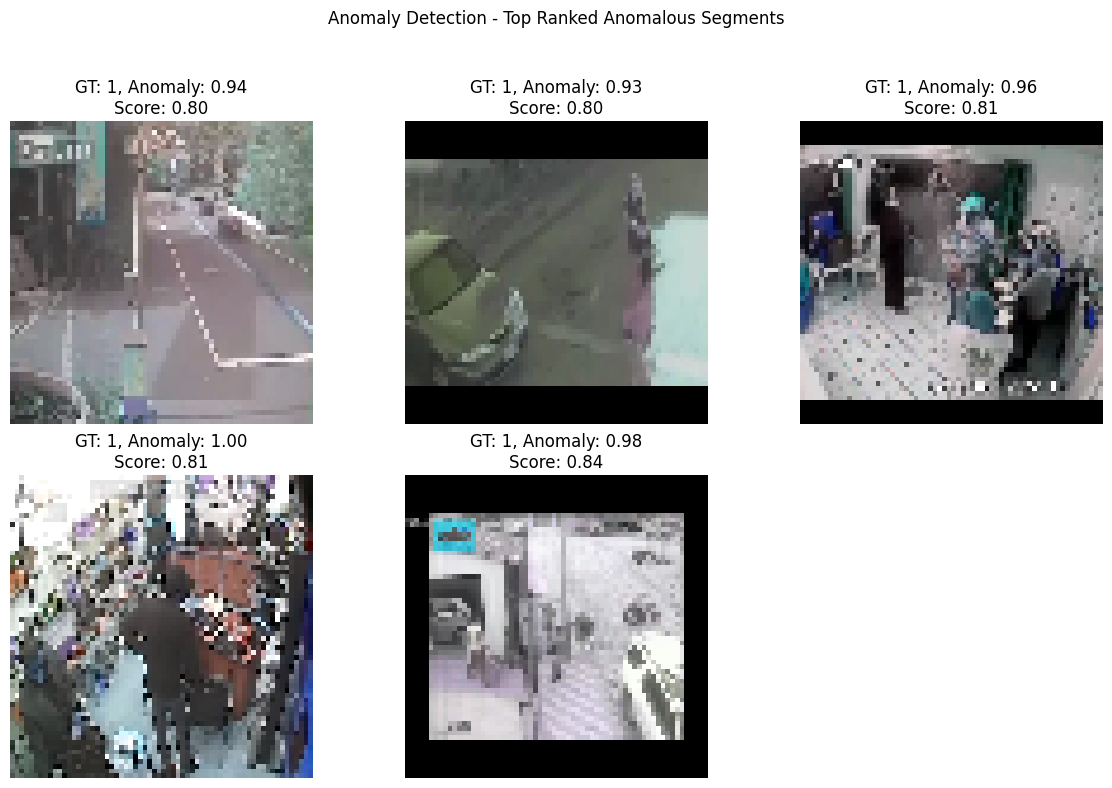

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Assuming 'fc_classifier' is already trained and loaded
# X_test_features, X_test (video segments), y_test (ground truth labels) are preloaded

# Scoring Mechanism: Compute segment scores based on pre-defined criteria
def compute_segment_score(memorability, entropy, temporal_dynamics, weights=(0.5, 0.3, 0.2)):
    # Adjust weights for memorability, entropy, and temporal dynamics
    return (weights[0] * memorability) + (weights[1] * entropy) + (weights[2] * temporal_dynamics)

# Example scoring function (dummy values for illustration)
# Replace memorability, entropy, and temporal_dynamics with actual calculations
memorability_scores = np.random.rand(len(X_test_features))  # placeholder
entropy_scores = np.random.rand(len(X_test_features))       # placeholder
temporal_dynamics_scores = np.random.rand(len(X_test_features))  # placeholder

# Calculate total scores for each segment
segment_scores = [
    compute_segment_score(m, e, t)
    for m, e, t in zip(memorability_scores, entropy_scores, temporal_dynamics_scores)
]

# Predict anomaly probabilities for all test features
predictions = fc_classifier.predict(X_test_features)
anomaly_scores = predictions[:, 0]  # Assuming a single output representing anomaly probability

# Combine model predictions with custom scores for final ranking
combined_scores = [a * s for a, s in zip(anomaly_scores, segment_scores)]
top_segments = np.argsort(combined_scores)[-5:]  # Select top 5 segments with highest combined scores


# Dynamically calculate rows and columns for plotting
num_top_segments = len(top_segments)
cols = min(num_top_segments, 3)  # Number of columns (adjust as needed)
rows = (num_top_segments + cols - 1) // cols  # Calculate the required rows

# Visualize top segments with scores, predictions, and ground truth
plt.figure(figsize=(4 * cols, 4 * rows))
for i, idx in enumerate(top_segments):
    segment = X_test[idx]           # Original video segment
    first_image = segment[0]         # First frame of the segment
    ground_truth = y_test[idx]       # Actual label for the segment
    prediction = anomaly_scores[idx] # Predicted anomaly probability
    score = combined_scores[idx]     # Combined score for ranking

    # Plot each selected keyframe with annotations
    plt.subplot(rows, cols, i + 1)
    plt.imshow(first_image)
    plt.title(f"GT: {ground_truth}, Anomaly: {prediction:.2f}\nScore: {score:.2f}")
    plt.axis('off')

plt.suptitle("Anomaly Detection - Top Ranked Anomalous Segments")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



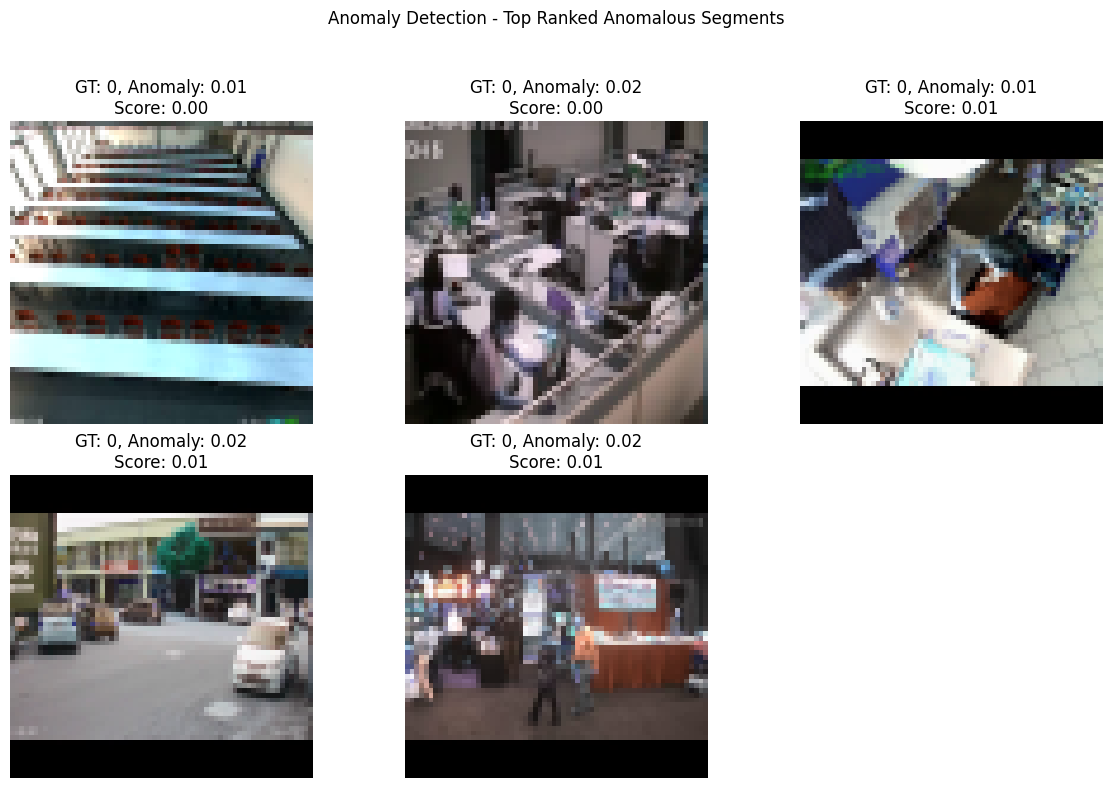

In [24]:
last_segments = np.argsort(combined_scores)[:5]  # Select top 5 segments with highest combined scores

# Dynamically calculate rows and columns for plotting
num_last_segments = len(last_segments)
cols = min(num_last_segments, 3)  # Number of columns (adjust as needed)
rows = (num_last_segments + cols - 1) // cols  # Calculate the required rows

# Visualize top segments with scores, predictions, and ground truth
plt.figure(figsize=(4 * cols, 4 * rows))
for i, idx in enumerate(last_segments):
    segment = X_test[idx]           # Original video segment
    first_image = segment[0]         # First frame of the segment
    ground_truth = y_test[idx]       # Actual label for the segment
    prediction = anomaly_scores[idx] # Predicted anomaly probability
    score = combined_scores[idx]     # Combined score for ranking

    # Plot each selected keyframe with annotations
    plt.subplot(rows, cols, i + 1)
    plt.imshow(first_image)
    plt.title(f"GT: {ground_truth}, Anomaly: {prediction:.2f}\nScore: {score:.2f}")
    plt.axis('off')

plt.suptitle("Anomaly Detection - Top Ranked Anomalous Segments")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


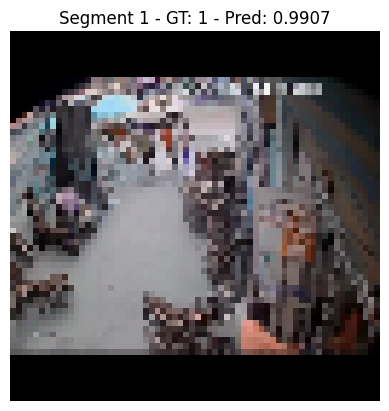

Segment 1 - GT: 1 - Anomaly Probability: 0.9907


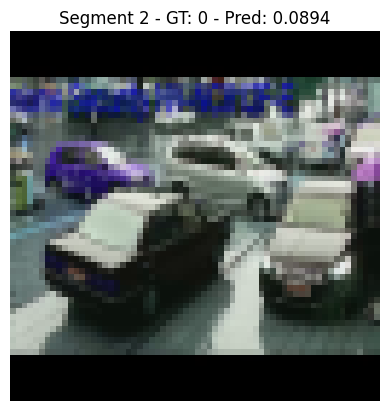

Segment 2 - GT: 0 - Anomaly Probability: 0.0894


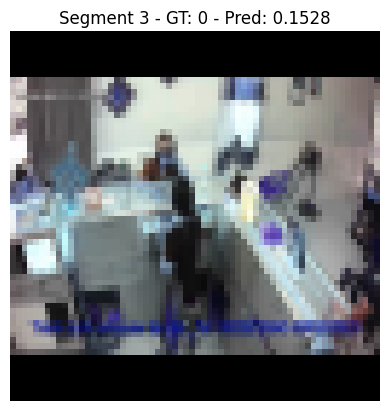

Segment 3 - GT: 0 - Anomaly Probability: 0.1528


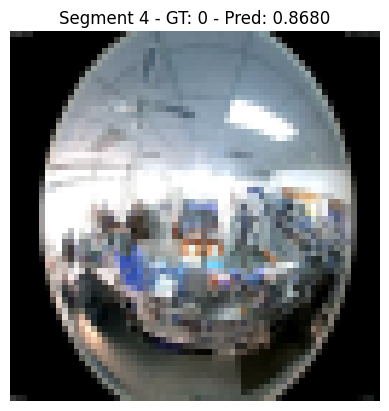

Segment 4 - GT: 0 - Anomaly Probability: 0.8680


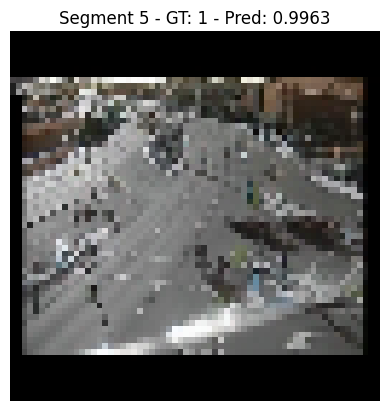

Segment 5 - GT: 1 - Anomaly Probability: 0.9963


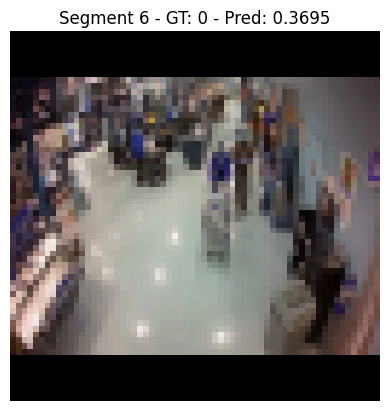

Segment 6 - GT: 0 - Anomaly Probability: 0.3695


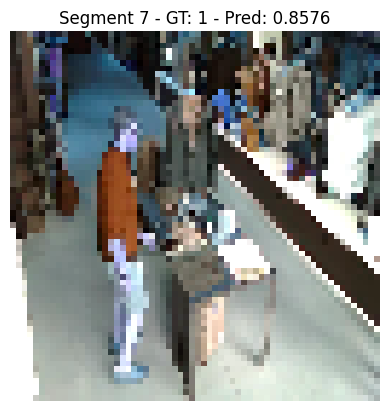

Segment 7 - GT: 1 - Anomaly Probability: 0.8576


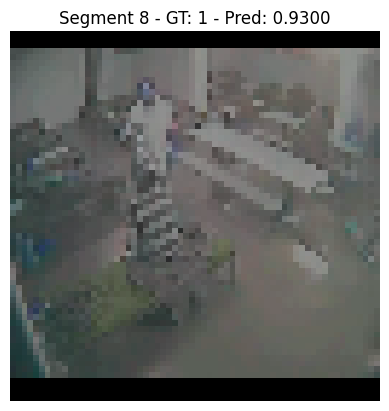

Segment 8 - GT: 1 - Anomaly Probability: 0.9300


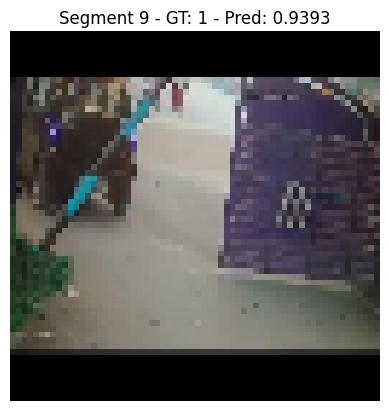

Segment 9 - GT: 1 - Anomaly Probability: 0.9393


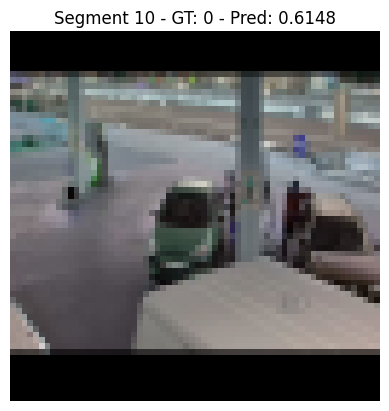

Segment 10 - GT: 0 - Anomaly Probability: 0.6148


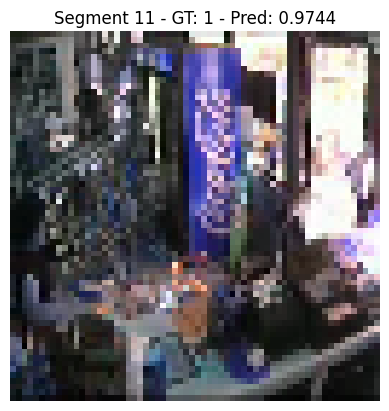

Segment 11 - GT: 1 - Anomaly Probability: 0.9744


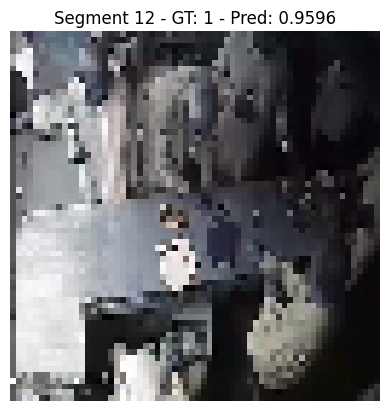

Segment 12 - GT: 1 - Anomaly Probability: 0.9596


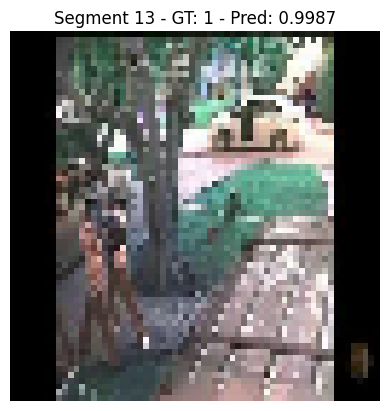

Segment 13 - GT: 1 - Anomaly Probability: 0.9987


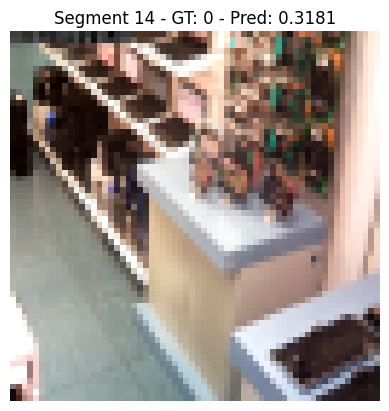

Segment 14 - GT: 0 - Anomaly Probability: 0.3181


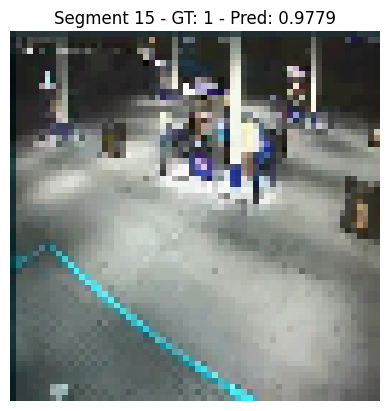

Segment 15 - GT: 1 - Anomaly Probability: 0.9779


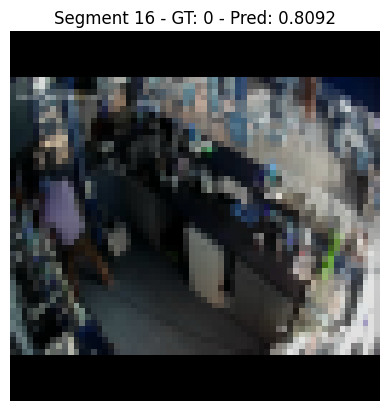

Segment 16 - GT: 0 - Anomaly Probability: 0.8092


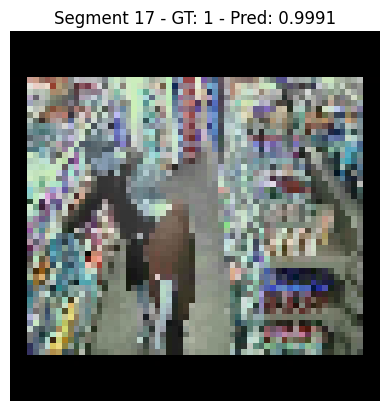

Segment 17 - GT: 1 - Anomaly Probability: 0.9991


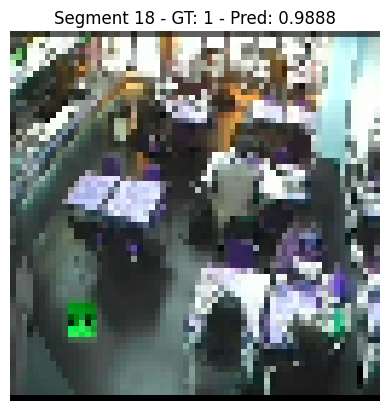

Segment 18 - GT: 1 - Anomaly Probability: 0.9888


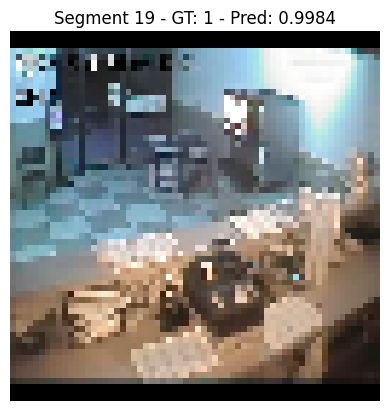

Segment 19 - GT: 1 - Anomaly Probability: 0.9984


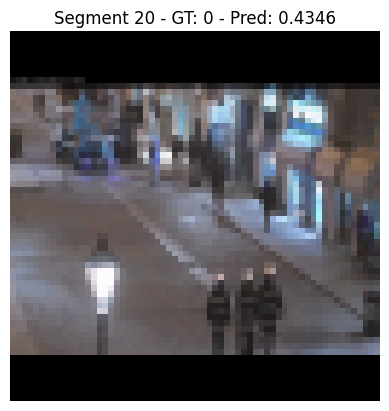

Segment 20 - GT: 0 - Anomaly Probability: 0.4346


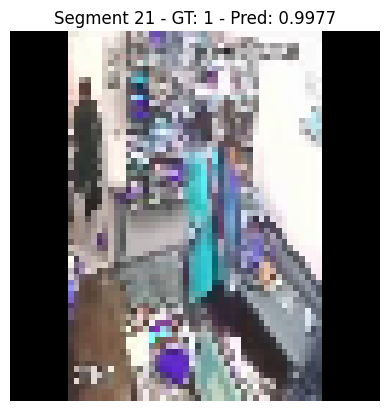

Segment 21 - GT: 1 - Anomaly Probability: 0.9977


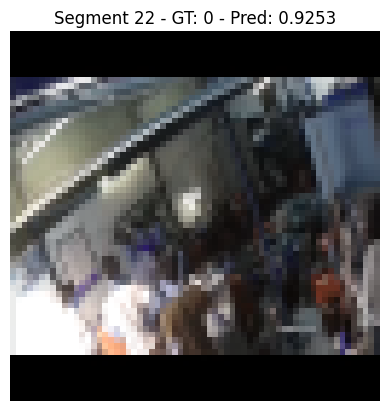

Segment 22 - GT: 0 - Anomaly Probability: 0.9253


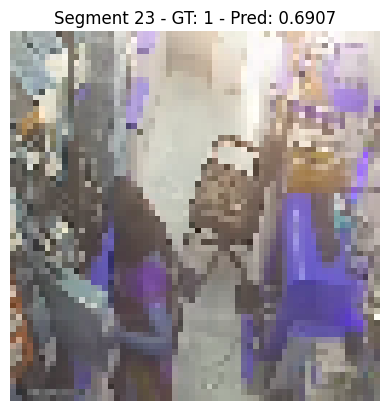

Segment 23 - GT: 1 - Anomaly Probability: 0.6907


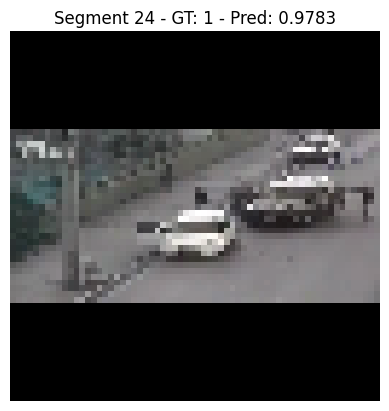

Segment 24 - GT: 1 - Anomaly Probability: 0.9783


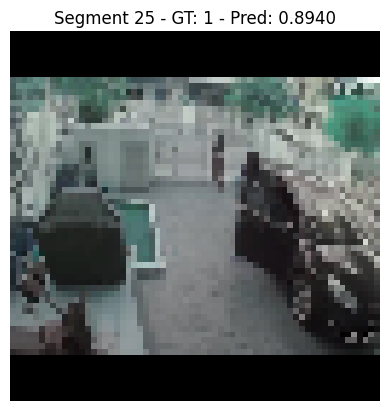

Segment 25 - GT: 1 - Anomaly Probability: 0.8940


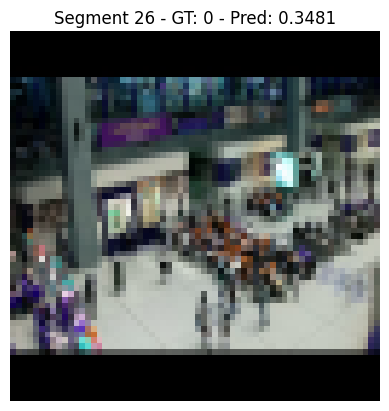

Segment 26 - GT: 0 - Anomaly Probability: 0.3481


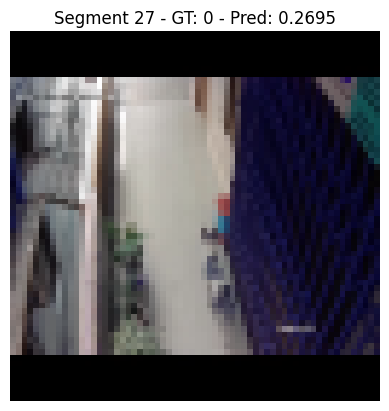

Segment 27 - GT: 0 - Anomaly Probability: 0.2695


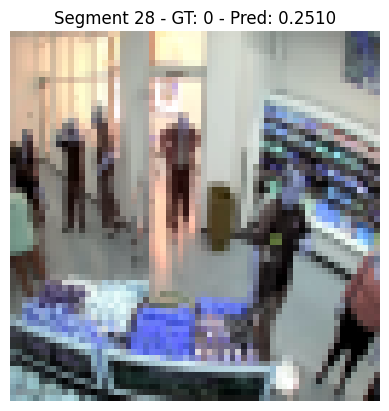

Segment 28 - GT: 0 - Anomaly Probability: 0.2510


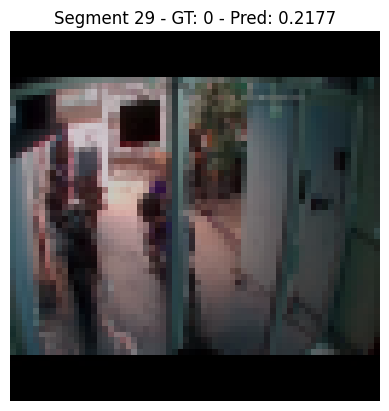

Segment 29 - GT: 0 - Anomaly Probability: 0.2177


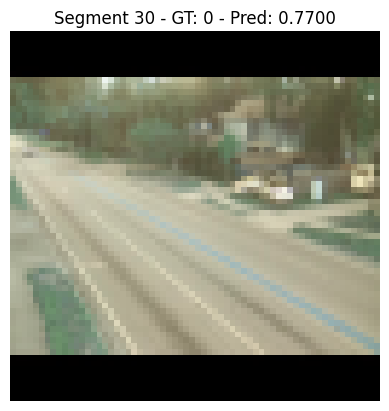

Segment 30 - GT: 0 - Anomaly Probability: 0.7700


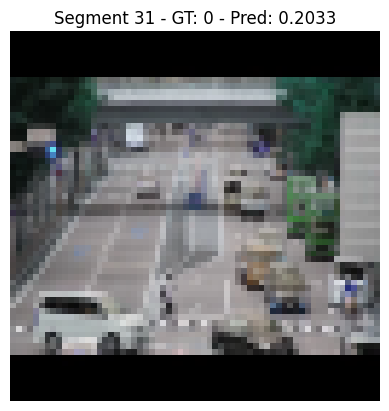

Segment 31 - GT: 0 - Anomaly Probability: 0.2033


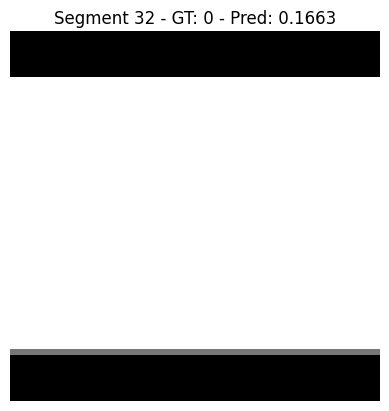

Segment 32 - GT: 0 - Anomaly Probability: 0.1663


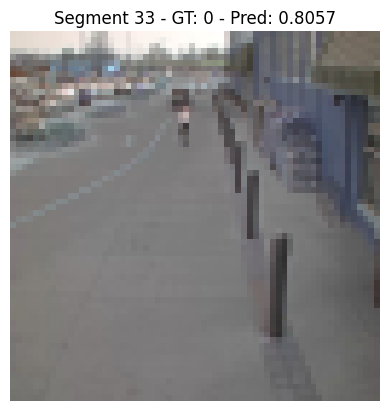

Segment 33 - GT: 0 - Anomaly Probability: 0.8057


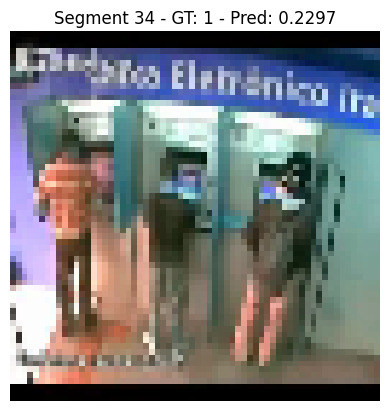

Segment 34 - GT: 1 - Anomaly Probability: 0.2297


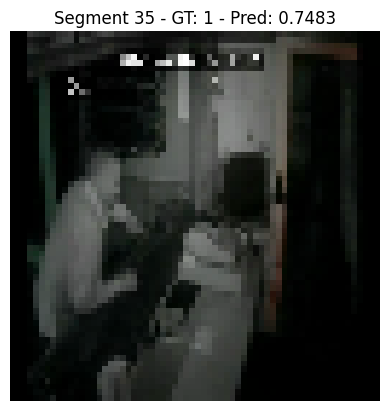

Segment 35 - GT: 1 - Anomaly Probability: 0.7483


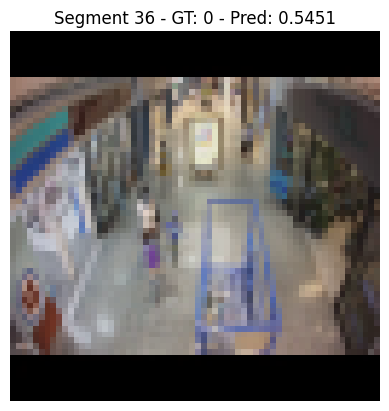

Segment 36 - GT: 0 - Anomaly Probability: 0.5451


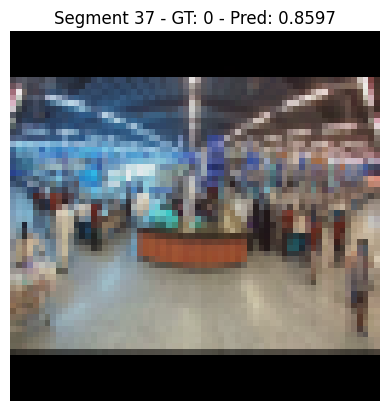

Segment 37 - GT: 0 - Anomaly Probability: 0.8597


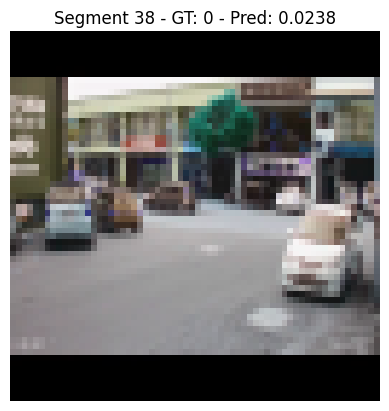

Segment 38 - GT: 0 - Anomaly Probability: 0.0238


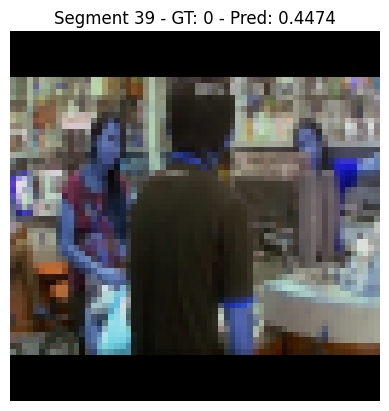

Segment 39 - GT: 0 - Anomaly Probability: 0.4474


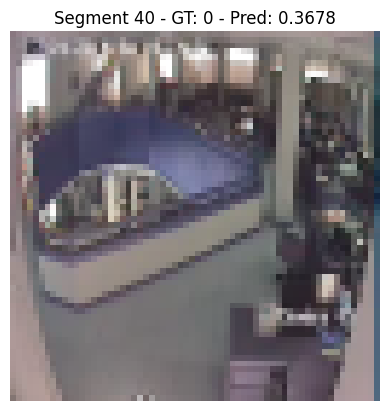

Segment 40 - GT: 0 - Anomaly Probability: 0.3678


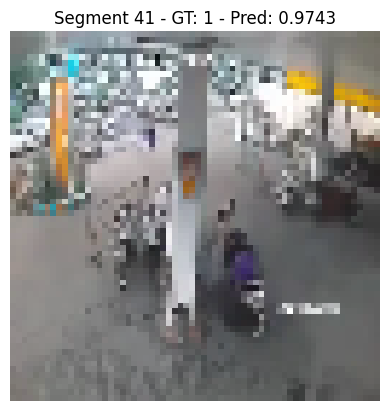

Segment 41 - GT: 1 - Anomaly Probability: 0.9743


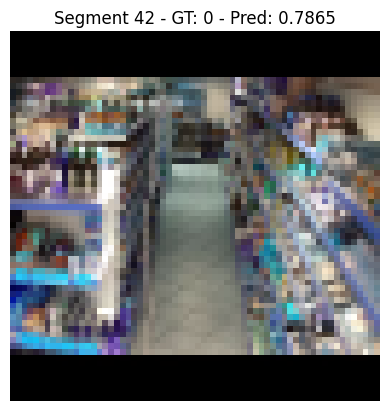

Segment 42 - GT: 0 - Anomaly Probability: 0.7865


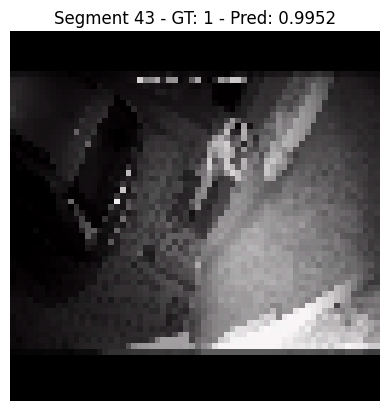

Segment 43 - GT: 1 - Anomaly Probability: 0.9952


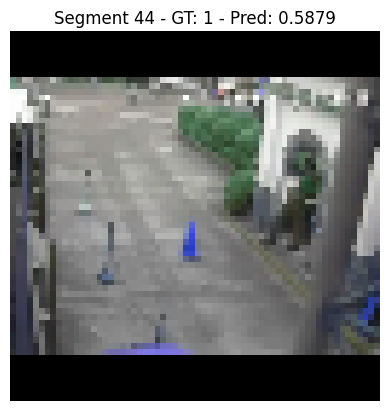

Segment 44 - GT: 1 - Anomaly Probability: 0.5879


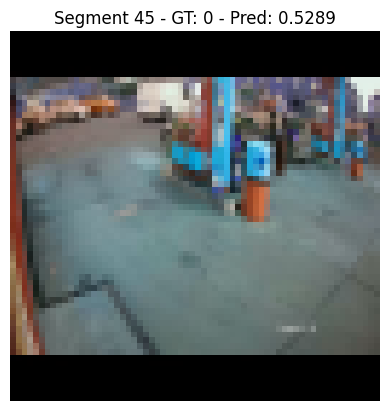

Segment 45 - GT: 0 - Anomaly Probability: 0.5289


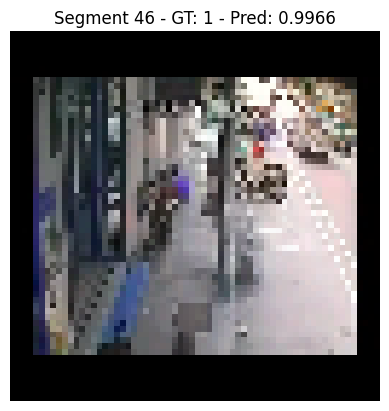

Segment 46 - GT: 1 - Anomaly Probability: 0.9966


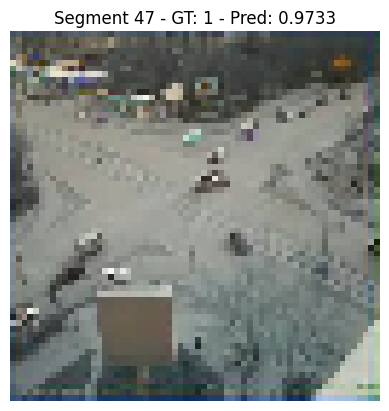

Segment 47 - GT: 1 - Anomaly Probability: 0.9733


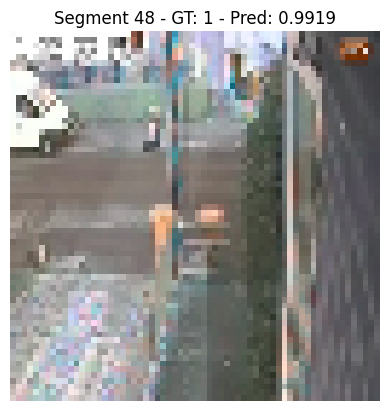

Segment 48 - GT: 1 - Anomaly Probability: 0.9919


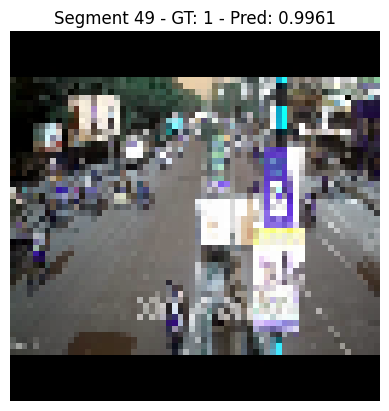

Segment 49 - GT: 1 - Anomaly Probability: 0.9961


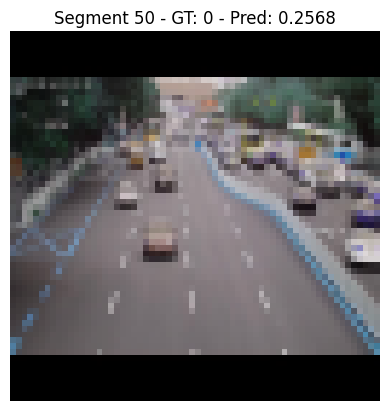

Segment 50 - GT: 0 - Anomaly Probability: 0.2568


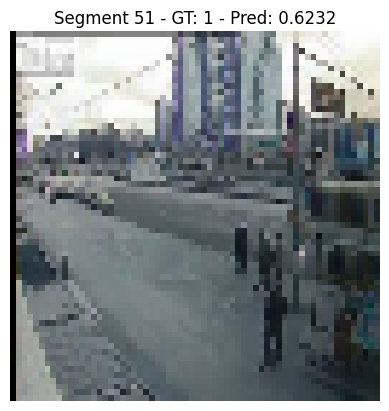

Segment 51 - GT: 1 - Anomaly Probability: 0.6232


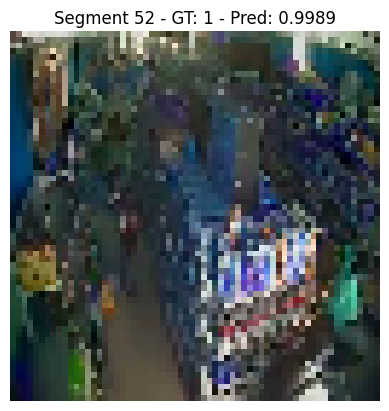

Segment 52 - GT: 1 - Anomaly Probability: 0.9989


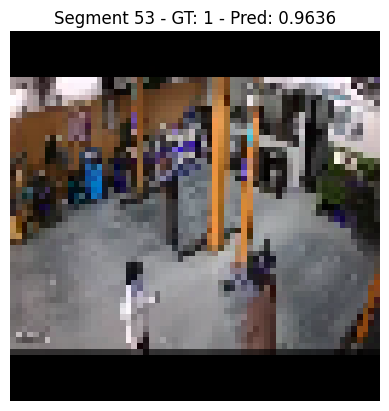

Segment 53 - GT: 1 - Anomaly Probability: 0.9636


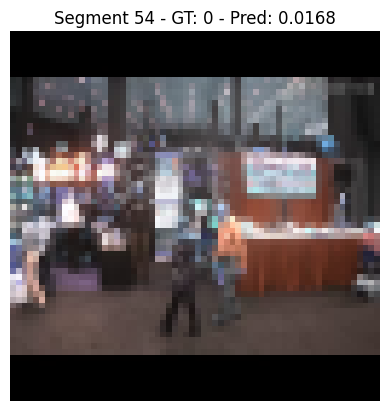

Segment 54 - GT: 0 - Anomaly Probability: 0.0168


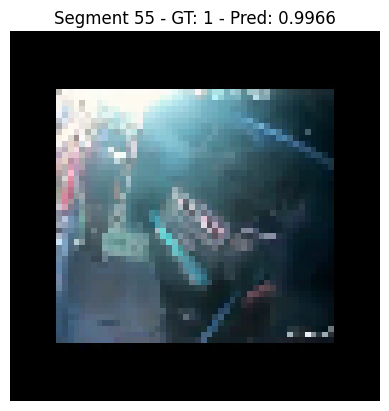

Segment 55 - GT: 1 - Anomaly Probability: 0.9966


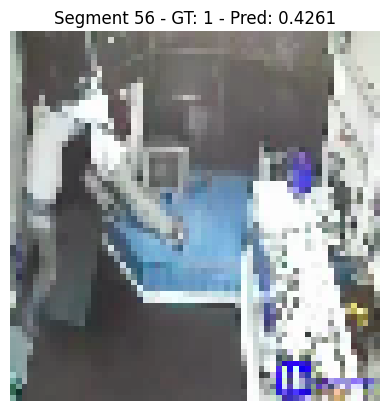

Segment 56 - GT: 1 - Anomaly Probability: 0.4261


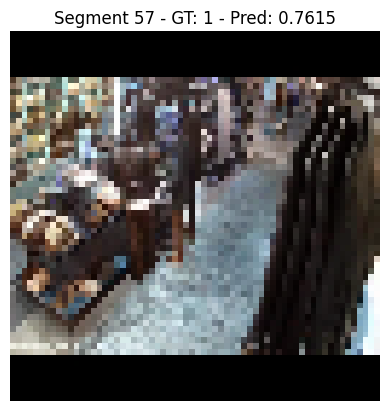

Segment 57 - GT: 1 - Anomaly Probability: 0.7615


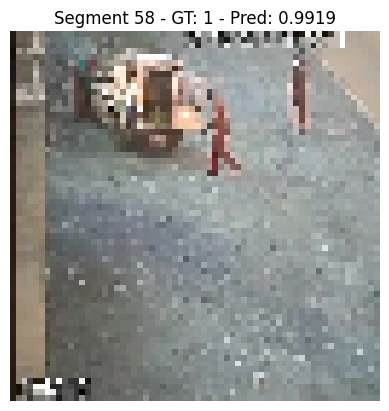

Segment 58 - GT: 1 - Anomaly Probability: 0.9919


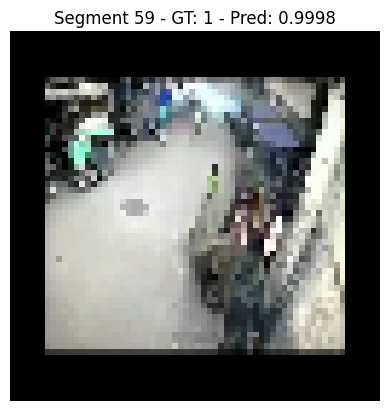

Segment 59 - GT: 1 - Anomaly Probability: 0.9998


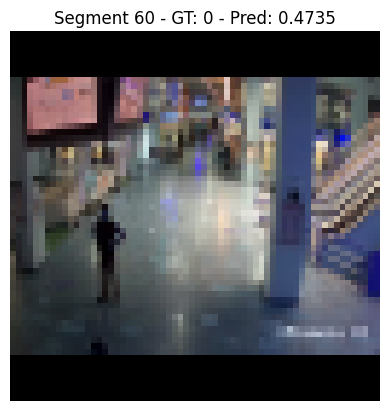

Segment 60 - GT: 0 - Anomaly Probability: 0.4735


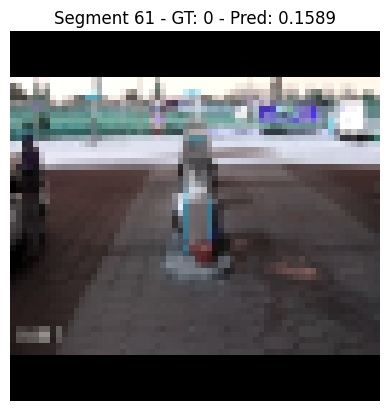

Segment 61 - GT: 0 - Anomaly Probability: 0.1589


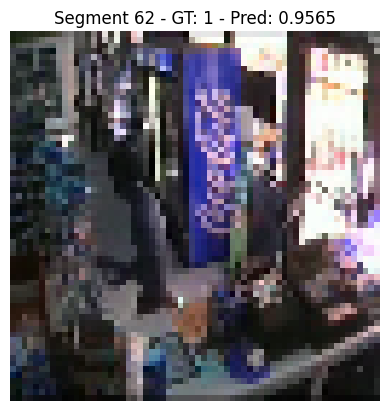

Segment 62 - GT: 1 - Anomaly Probability: 0.9565


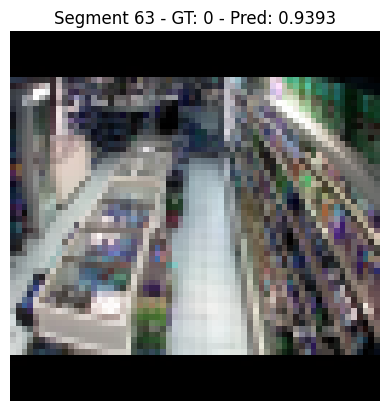

Segment 63 - GT: 0 - Anomaly Probability: 0.9393


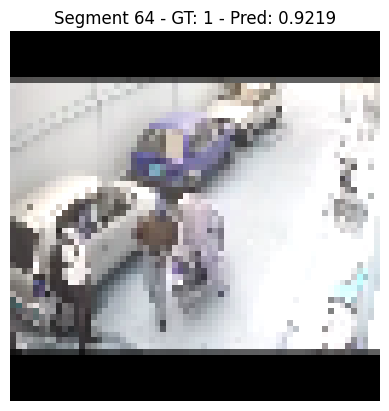

Segment 64 - GT: 1 - Anomaly Probability: 0.9219


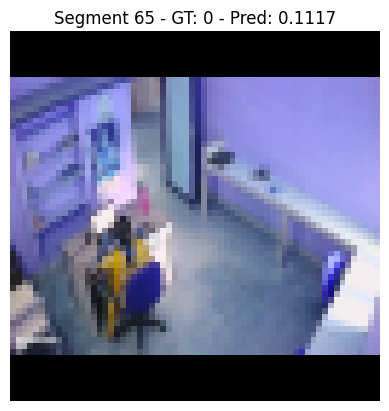

Segment 65 - GT: 0 - Anomaly Probability: 0.1117


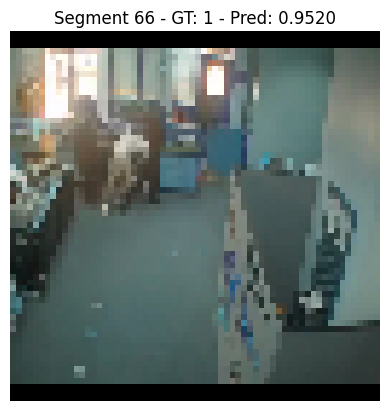

Segment 66 - GT: 1 - Anomaly Probability: 0.9520


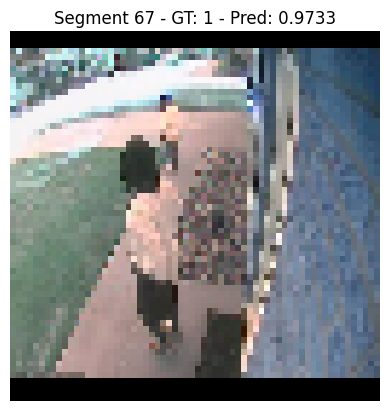

Segment 67 - GT: 1 - Anomaly Probability: 0.9733


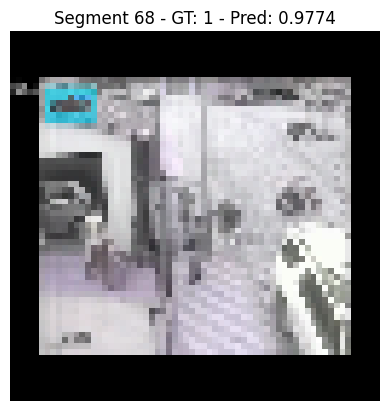

Segment 68 - GT: 1 - Anomaly Probability: 0.9774


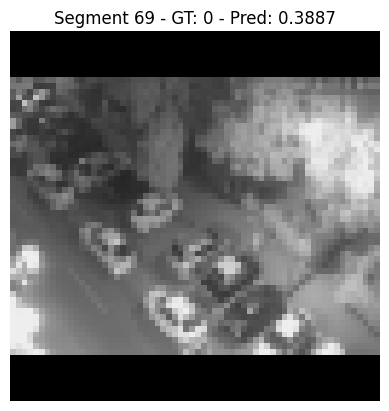

Segment 69 - GT: 0 - Anomaly Probability: 0.3887


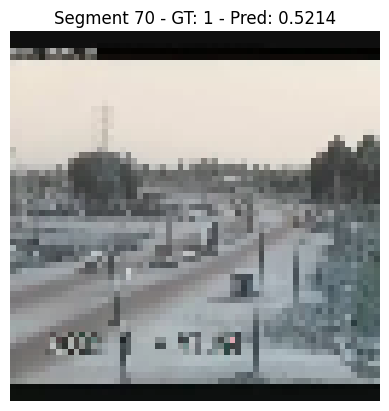

Segment 70 - GT: 1 - Anomaly Probability: 0.5214


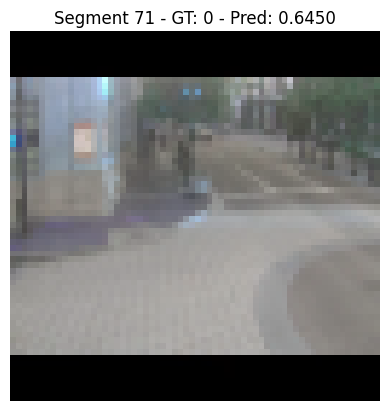

Segment 71 - GT: 0 - Anomaly Probability: 0.6450


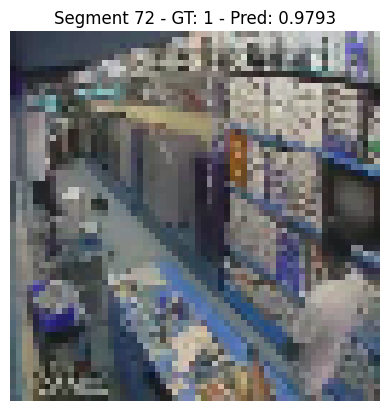

Segment 72 - GT: 1 - Anomaly Probability: 0.9793


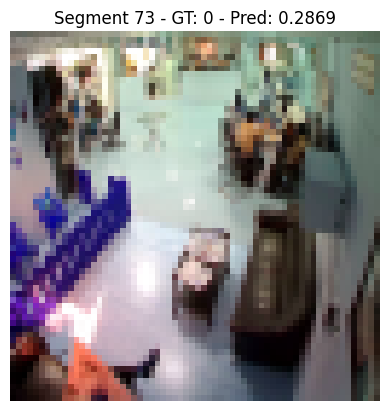

Segment 73 - GT: 0 - Anomaly Probability: 0.2869


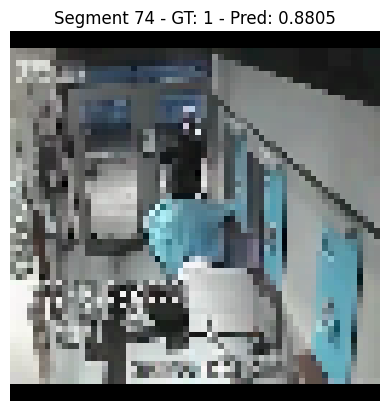

Segment 74 - GT: 1 - Anomaly Probability: 0.8805


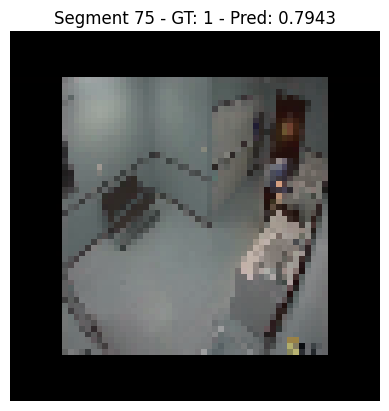

Segment 75 - GT: 1 - Anomaly Probability: 0.7943


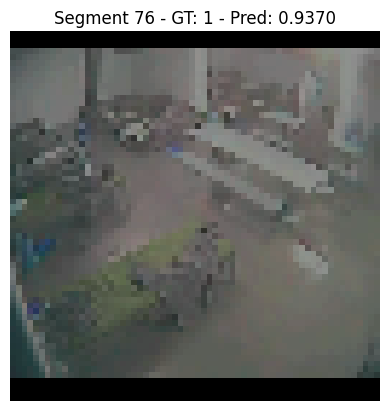

Segment 76 - GT: 1 - Anomaly Probability: 0.9370


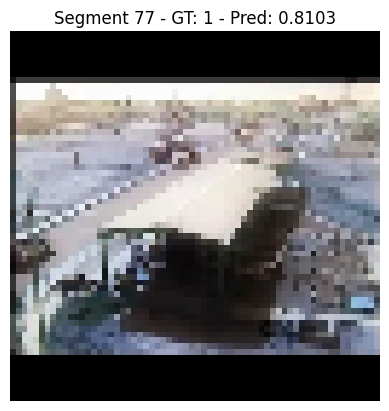

Segment 77 - GT: 1 - Anomaly Probability: 0.8103


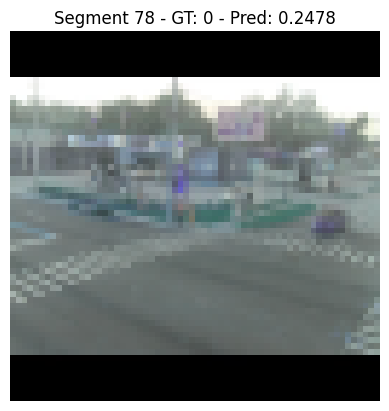

Segment 78 - GT: 0 - Anomaly Probability: 0.2478


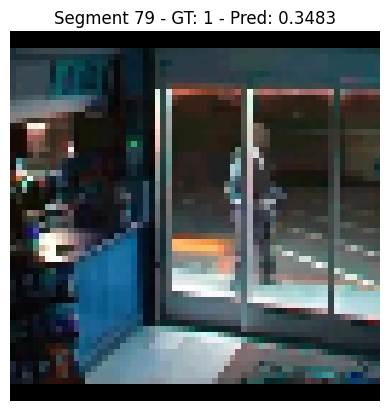

Segment 79 - GT: 1 - Anomaly Probability: 0.3483


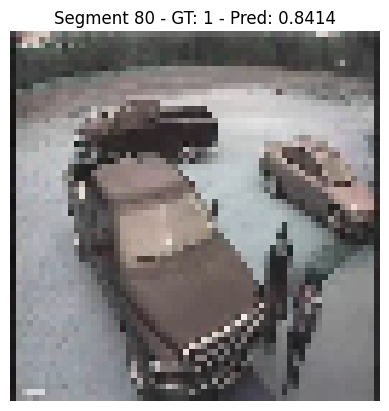

Segment 80 - GT: 1 - Anomaly Probability: 0.8414


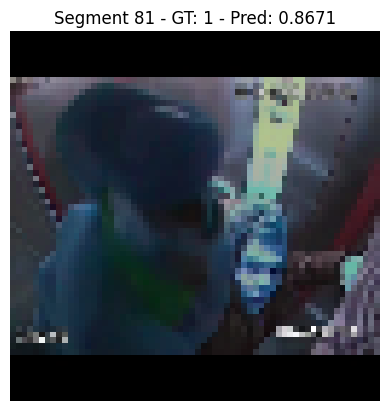

Segment 81 - GT: 1 - Anomaly Probability: 0.8671


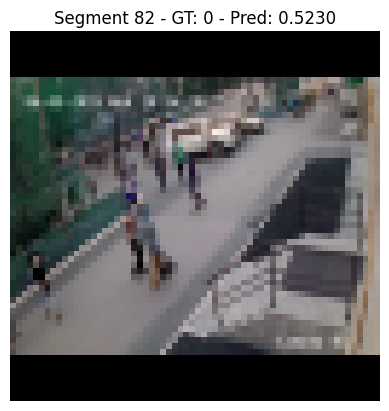

Segment 82 - GT: 0 - Anomaly Probability: 0.5230


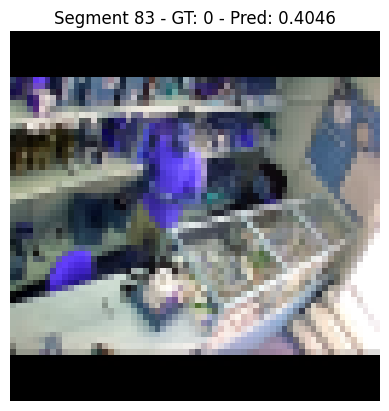

Segment 83 - GT: 0 - Anomaly Probability: 0.4046


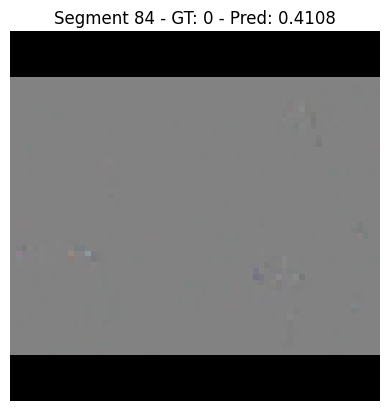

Segment 84 - GT: 0 - Anomaly Probability: 0.4108


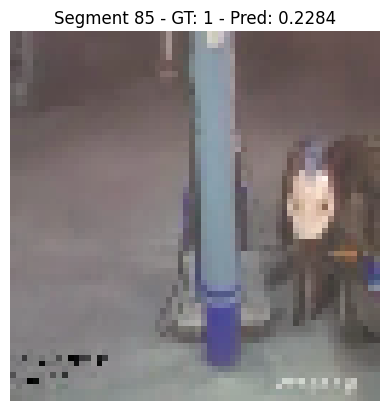

Segment 85 - GT: 1 - Anomaly Probability: 0.2284


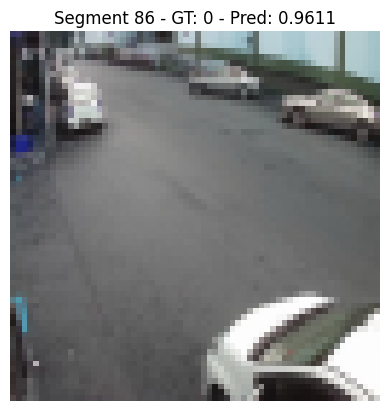

Segment 86 - GT: 0 - Anomaly Probability: 0.9611


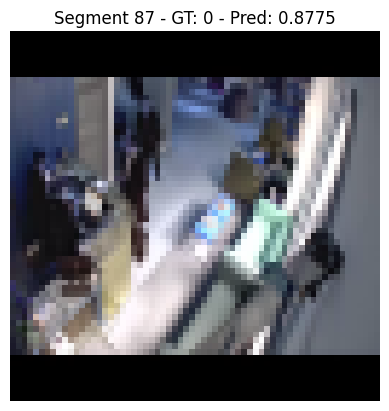

Segment 87 - GT: 0 - Anomaly Probability: 0.8775


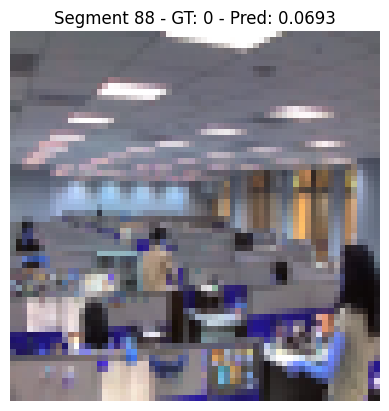

Segment 88 - GT: 0 - Anomaly Probability: 0.0693


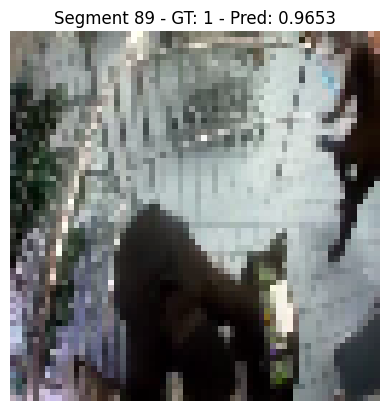

Segment 89 - GT: 1 - Anomaly Probability: 0.9653


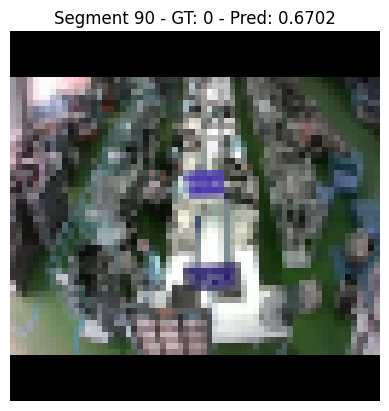

Segment 90 - GT: 0 - Anomaly Probability: 0.6702


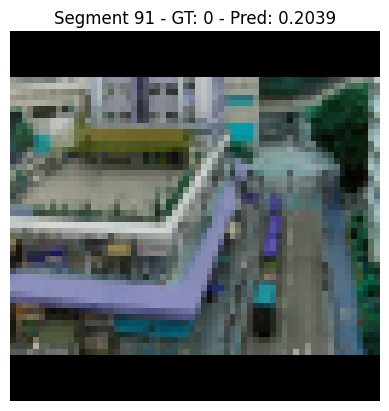

Segment 91 - GT: 0 - Anomaly Probability: 0.2039


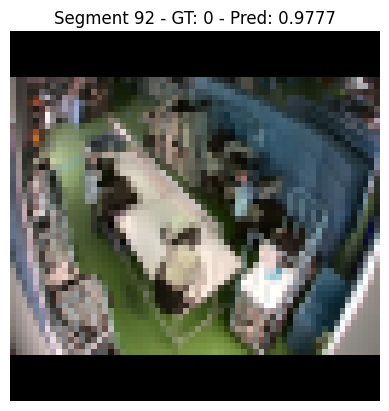

Segment 92 - GT: 0 - Anomaly Probability: 0.9777


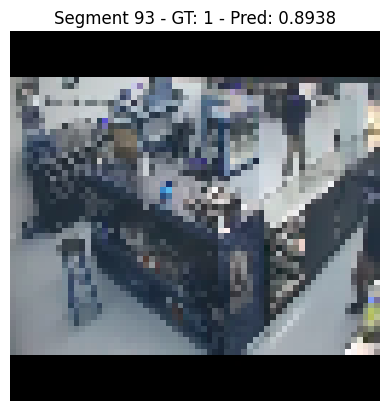

Segment 93 - GT: 1 - Anomaly Probability: 0.8938


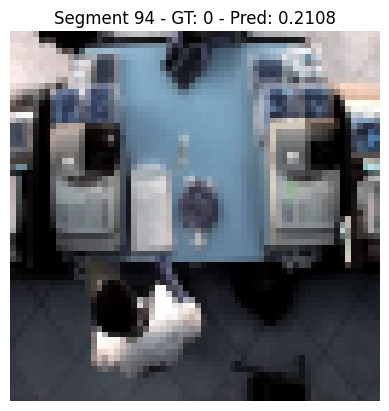

Segment 94 - GT: 0 - Anomaly Probability: 0.2108


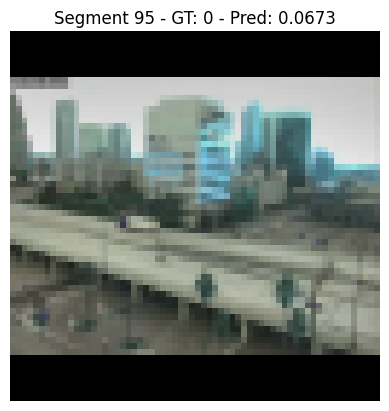

Segment 95 - GT: 0 - Anomaly Probability: 0.0673


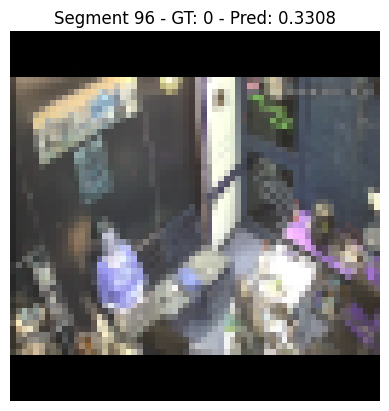

Segment 96 - GT: 0 - Anomaly Probability: 0.3308


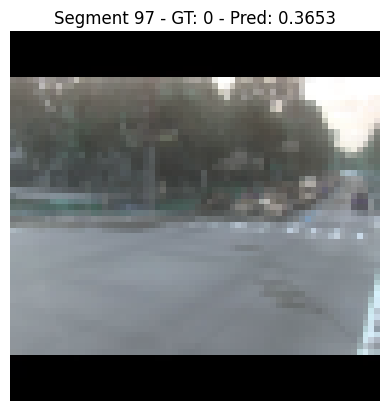

Segment 97 - GT: 0 - Anomaly Probability: 0.3653


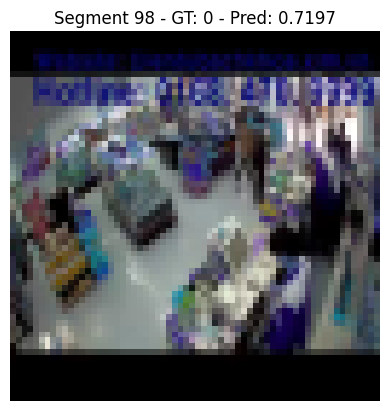

Segment 98 - GT: 0 - Anomaly Probability: 0.7197


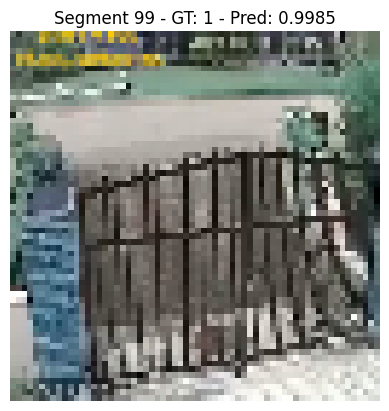

Segment 99 - GT: 1 - Anomaly Probability: 0.9985


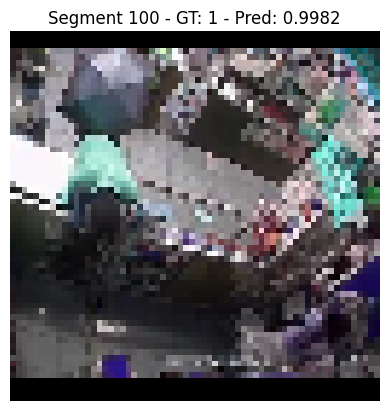

Segment 100 - GT: 1 - Anomaly Probability: 0.9982


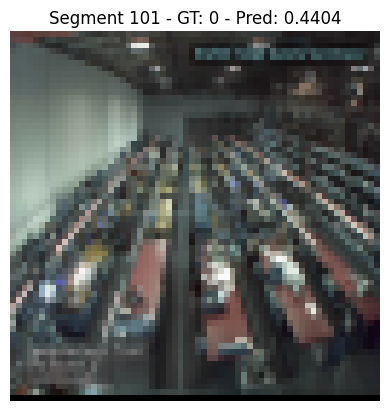

Segment 101 - GT: 0 - Anomaly Probability: 0.4404


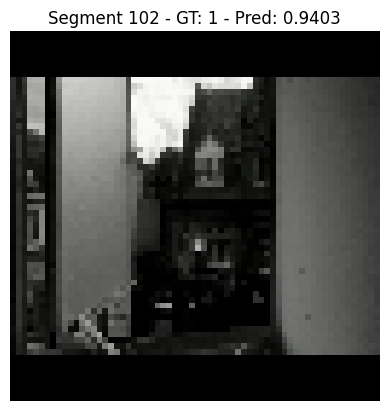

Segment 102 - GT: 1 - Anomaly Probability: 0.9403


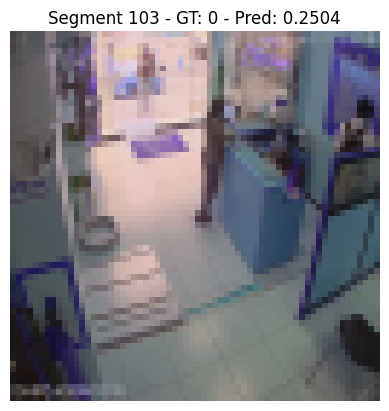

Segment 103 - GT: 0 - Anomaly Probability: 0.2504


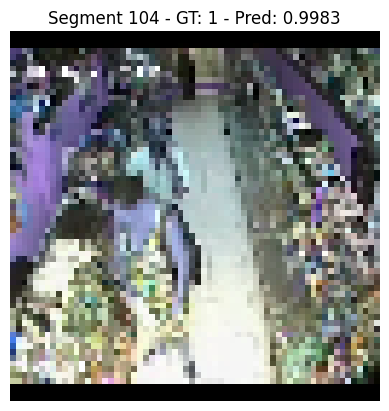

Segment 104 - GT: 1 - Anomaly Probability: 0.9983


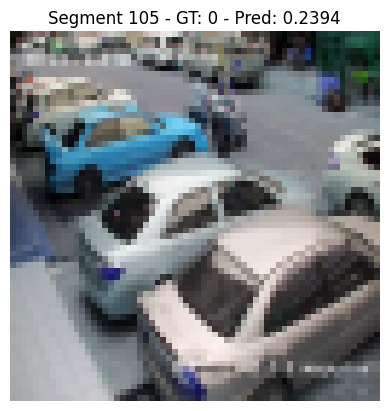

Segment 105 - GT: 0 - Anomaly Probability: 0.2394


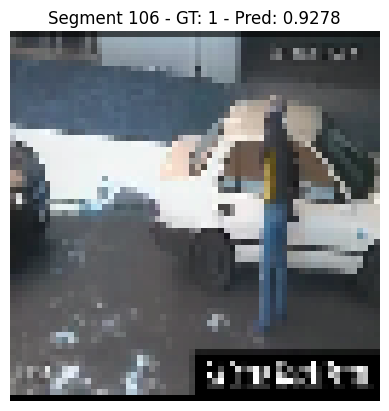

Segment 106 - GT: 1 - Anomaly Probability: 0.9278


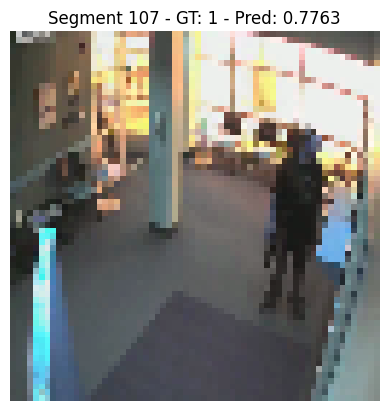

Segment 107 - GT: 1 - Anomaly Probability: 0.7763


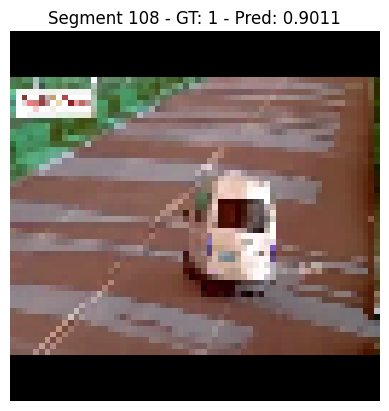

Segment 108 - GT: 1 - Anomaly Probability: 0.9011


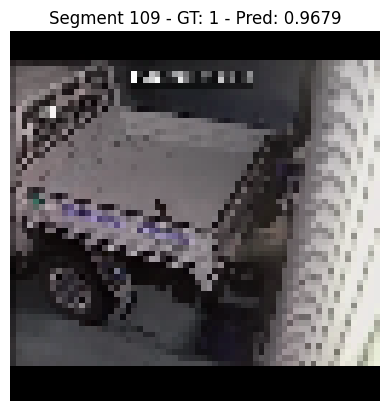

Segment 109 - GT: 1 - Anomaly Probability: 0.9679


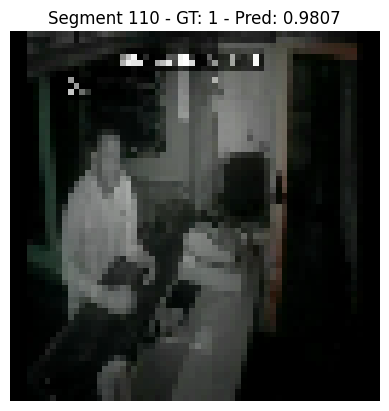

Segment 110 - GT: 1 - Anomaly Probability: 0.9807


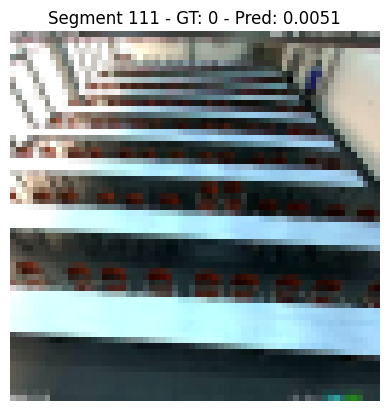

Segment 111 - GT: 0 - Anomaly Probability: 0.0051


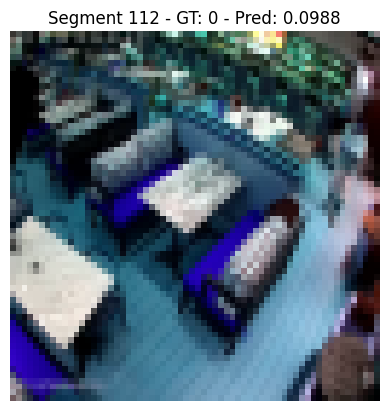

Segment 112 - GT: 0 - Anomaly Probability: 0.0988


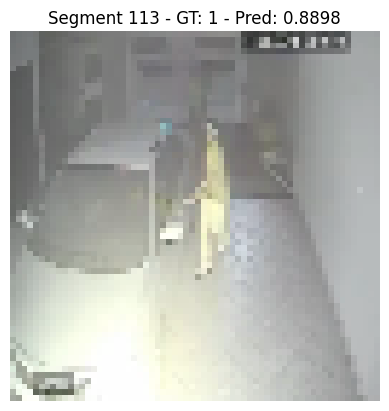

Segment 113 - GT: 1 - Anomaly Probability: 0.8898


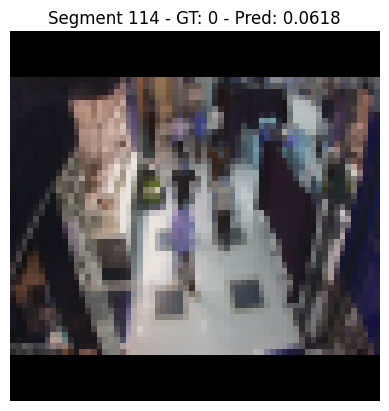

Segment 114 - GT: 0 - Anomaly Probability: 0.0618


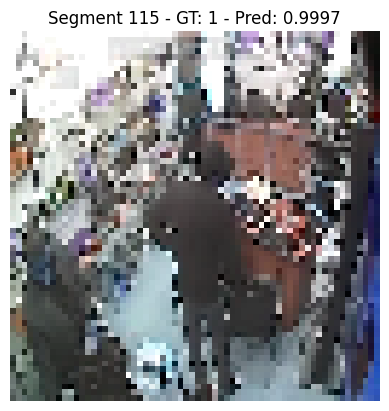

Segment 115 - GT: 1 - Anomaly Probability: 0.9997


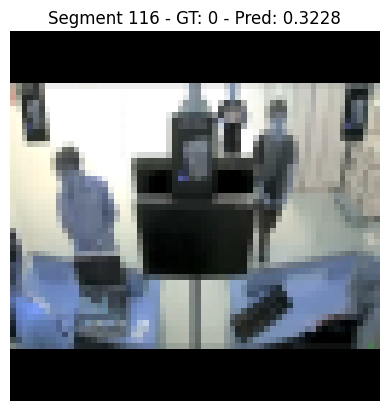

Segment 116 - GT: 0 - Anomaly Probability: 0.3228


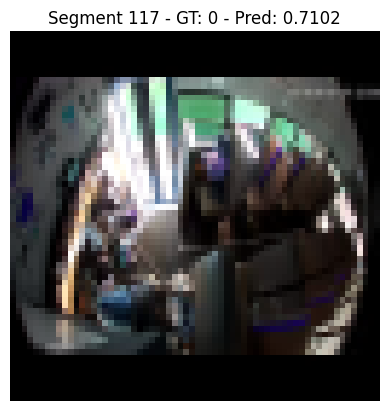

Segment 117 - GT: 0 - Anomaly Probability: 0.7102


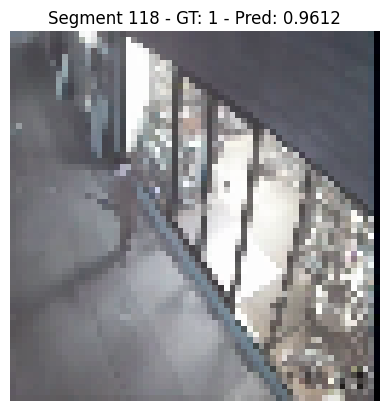

Segment 118 - GT: 1 - Anomaly Probability: 0.9612


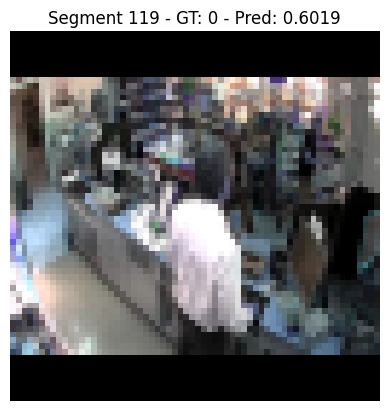

Segment 119 - GT: 0 - Anomaly Probability: 0.6019


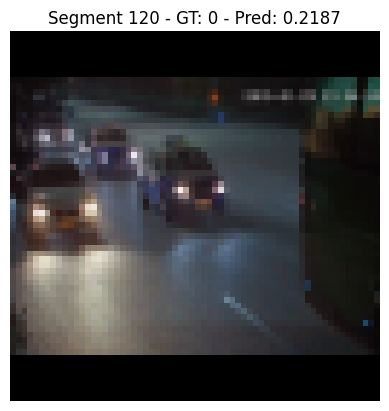

Segment 120 - GT: 0 - Anomaly Probability: 0.2187


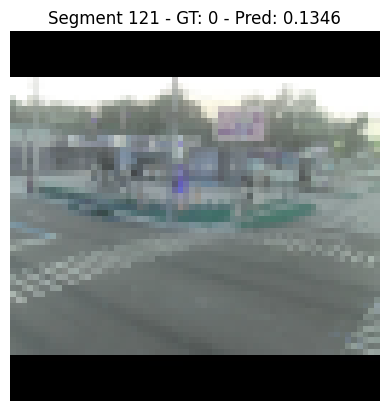

Segment 121 - GT: 0 - Anomaly Probability: 0.1346


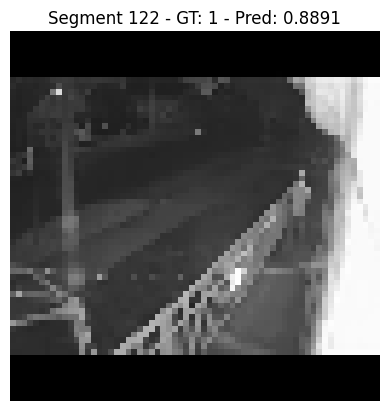

Segment 122 - GT: 1 - Anomaly Probability: 0.8891


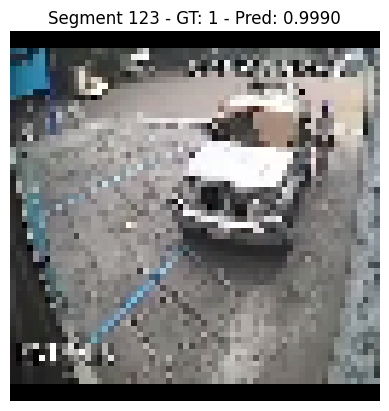

Segment 123 - GT: 1 - Anomaly Probability: 0.9990


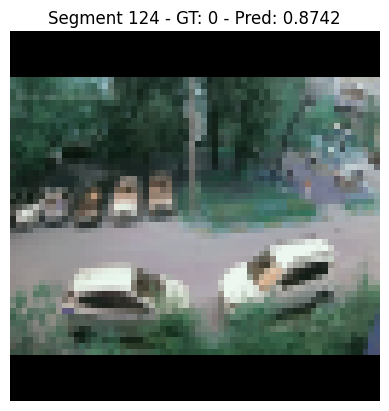

Segment 124 - GT: 0 - Anomaly Probability: 0.8742


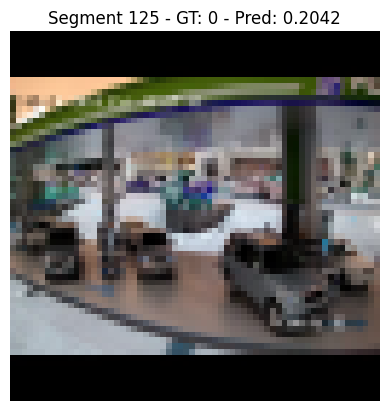

Segment 125 - GT: 0 - Anomaly Probability: 0.2042


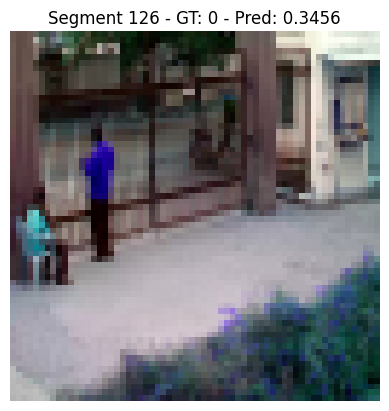

Segment 126 - GT: 0 - Anomaly Probability: 0.3456


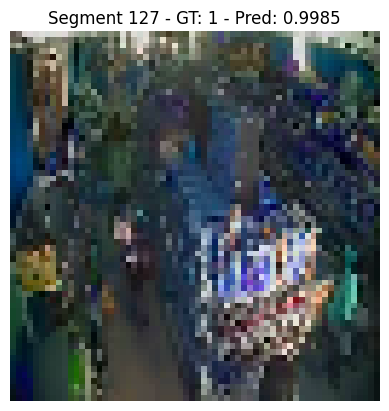

Segment 127 - GT: 1 - Anomaly Probability: 0.9985


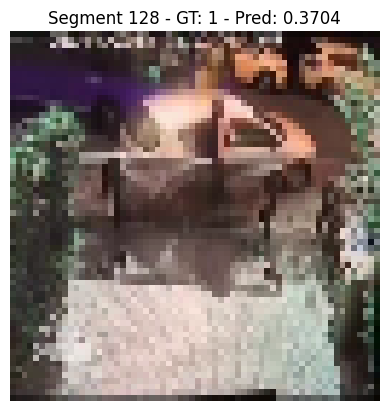

Segment 128 - GT: 1 - Anomaly Probability: 0.3704


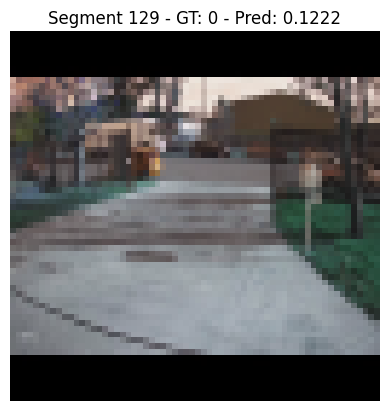

Segment 129 - GT: 0 - Anomaly Probability: 0.1222


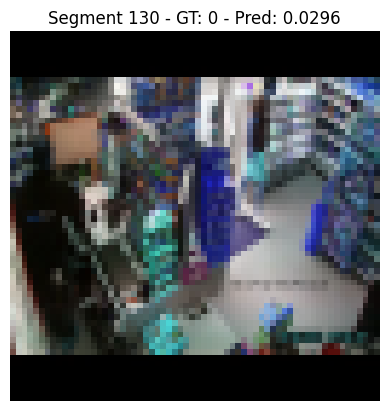

Segment 130 - GT: 0 - Anomaly Probability: 0.0296


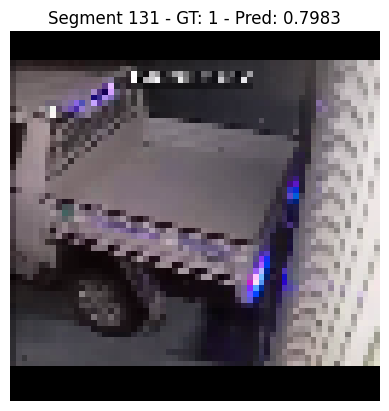

Segment 131 - GT: 1 - Anomaly Probability: 0.7983


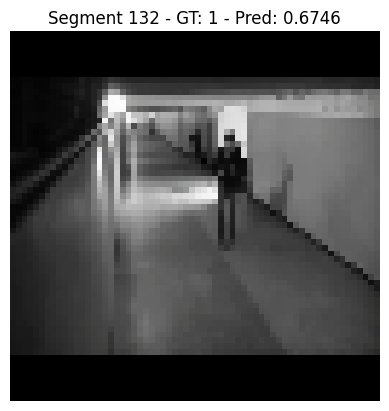

Segment 132 - GT: 1 - Anomaly Probability: 0.6746


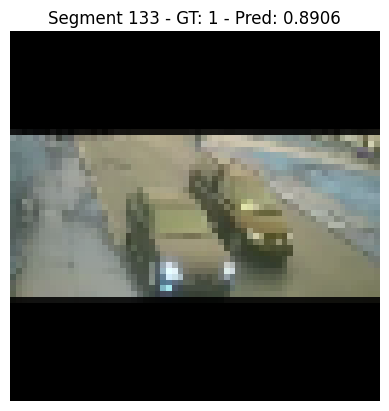

Segment 133 - GT: 1 - Anomaly Probability: 0.8906


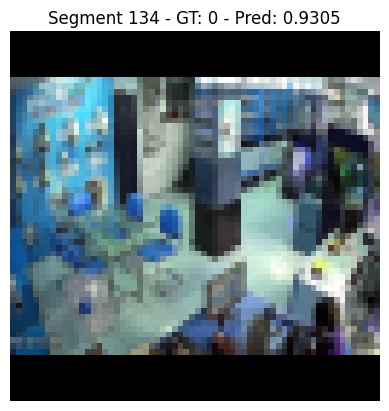

Segment 134 - GT: 0 - Anomaly Probability: 0.9305


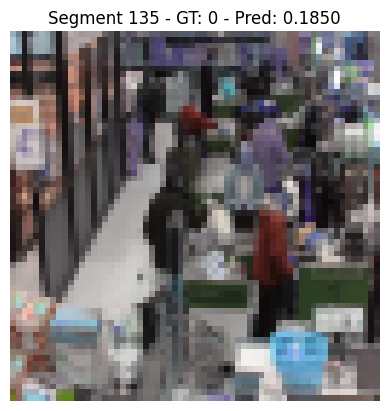

Segment 135 - GT: 0 - Anomaly Probability: 0.1850


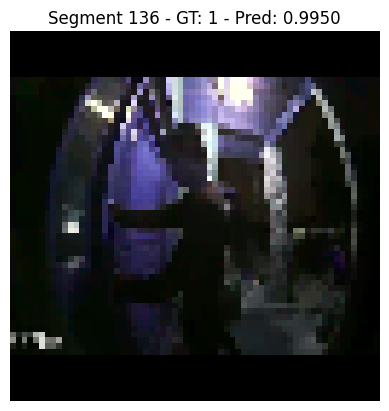

Segment 136 - GT: 1 - Anomaly Probability: 0.9950


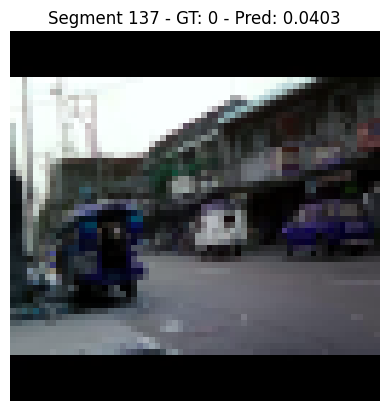

Segment 137 - GT: 0 - Anomaly Probability: 0.0403


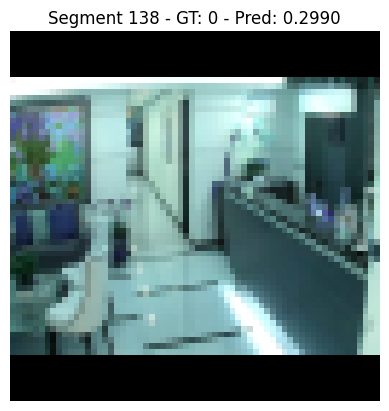

Segment 138 - GT: 0 - Anomaly Probability: 0.2990


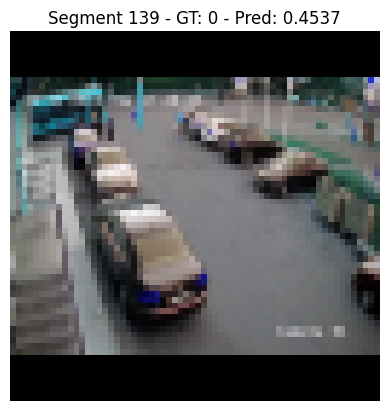

Segment 139 - GT: 0 - Anomaly Probability: 0.4537


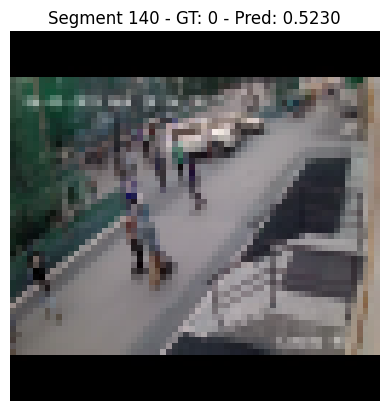

Segment 140 - GT: 0 - Anomaly Probability: 0.5230


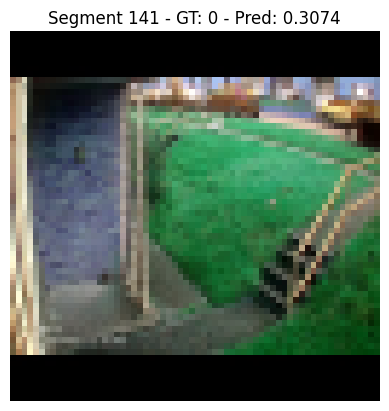

Segment 141 - GT: 0 - Anomaly Probability: 0.3074


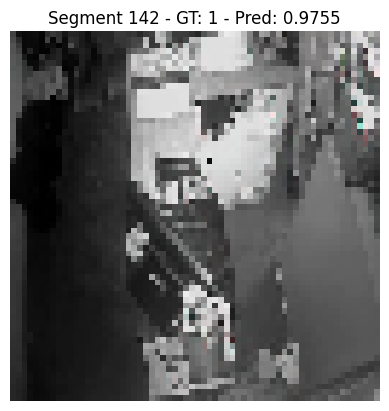

Segment 142 - GT: 1 - Anomaly Probability: 0.9755


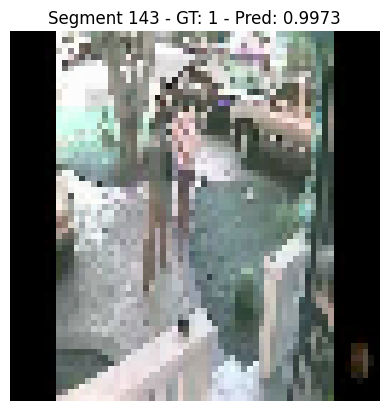

Segment 143 - GT: 1 - Anomaly Probability: 0.9973


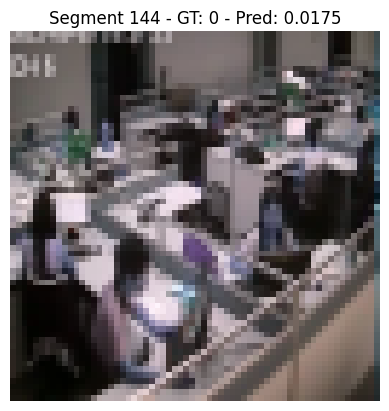

Segment 144 - GT: 0 - Anomaly Probability: 0.0175


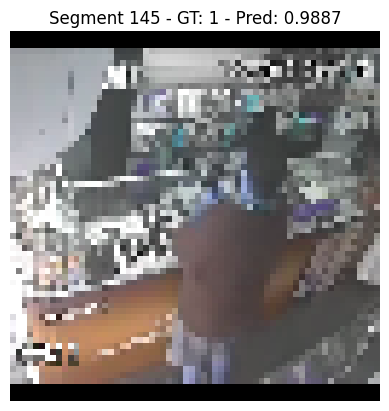

Segment 145 - GT: 1 - Anomaly Probability: 0.9887


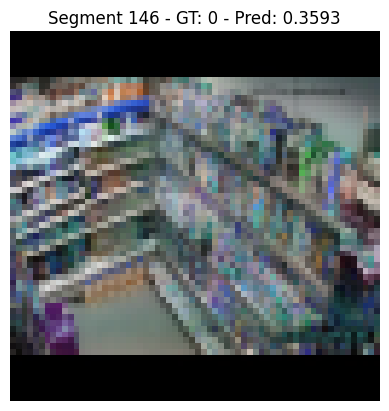

Segment 146 - GT: 0 - Anomaly Probability: 0.3593


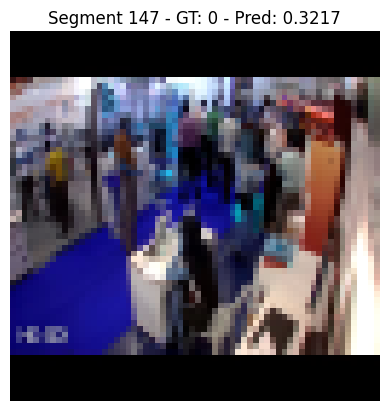

Segment 147 - GT: 0 - Anomaly Probability: 0.3217


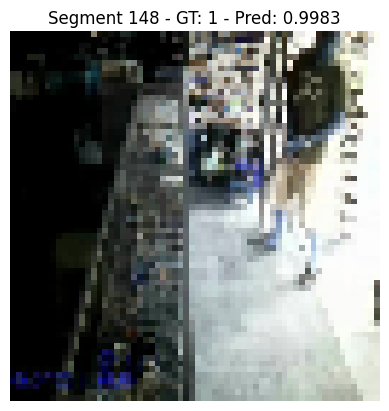

Segment 148 - GT: 1 - Anomaly Probability: 0.9983


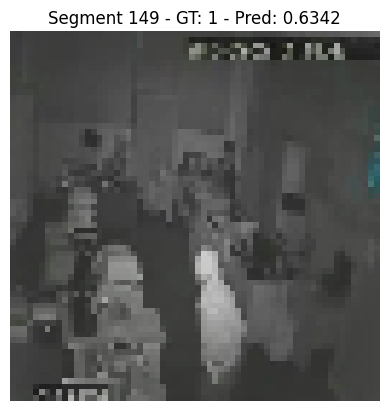

Segment 149 - GT: 1 - Anomaly Probability: 0.6342


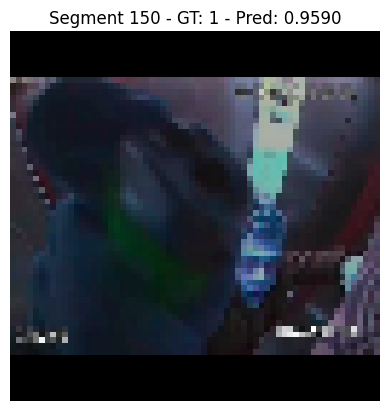

Segment 150 - GT: 1 - Anomaly Probability: 0.9590


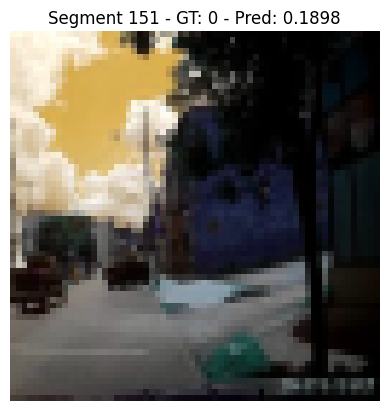

Segment 151 - GT: 0 - Anomaly Probability: 0.1898


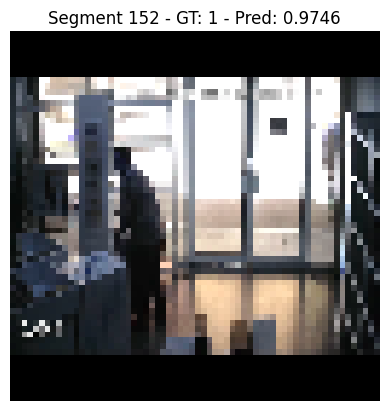

Segment 152 - GT: 1 - Anomaly Probability: 0.9746


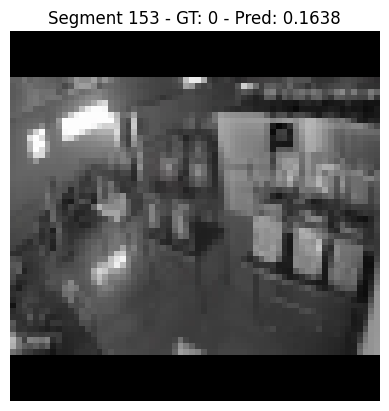

Segment 153 - GT: 0 - Anomaly Probability: 0.1638


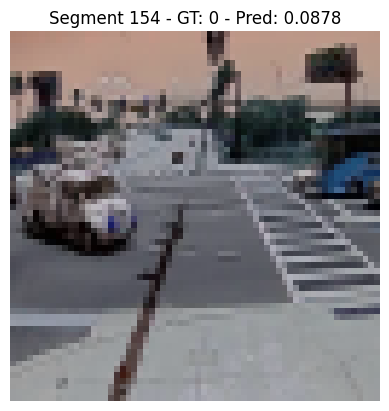

Segment 154 - GT: 0 - Anomaly Probability: 0.0878


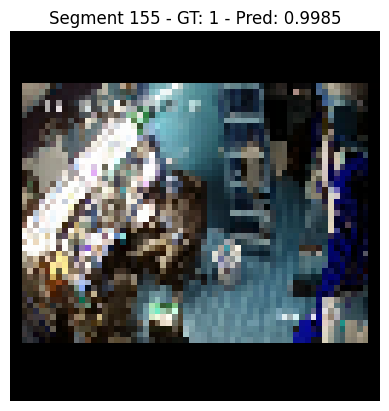

Segment 155 - GT: 1 - Anomaly Probability: 0.9985


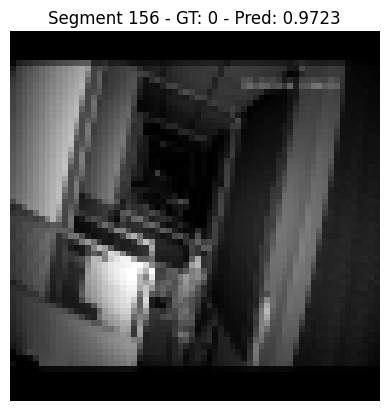

Segment 156 - GT: 0 - Anomaly Probability: 0.9723


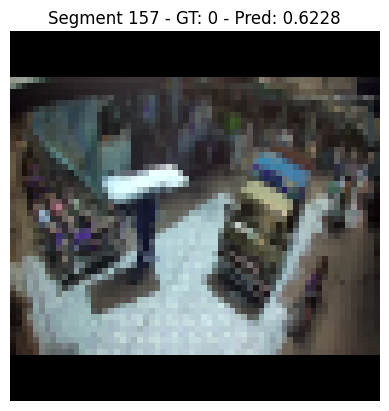

Segment 157 - GT: 0 - Anomaly Probability: 0.6228


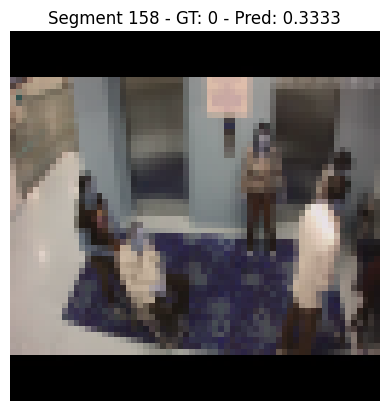

Segment 158 - GT: 0 - Anomaly Probability: 0.3333


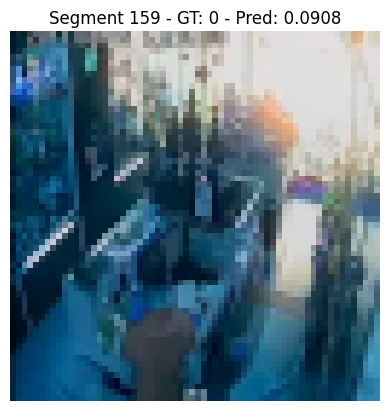

Segment 159 - GT: 0 - Anomaly Probability: 0.0908


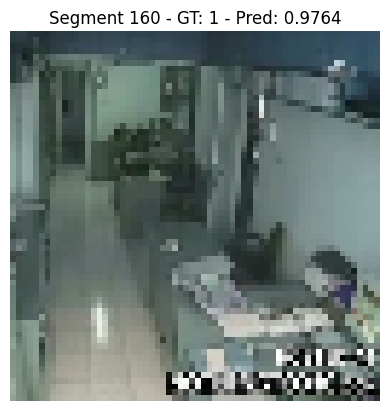

Segment 160 - GT: 1 - Anomaly Probability: 0.9764


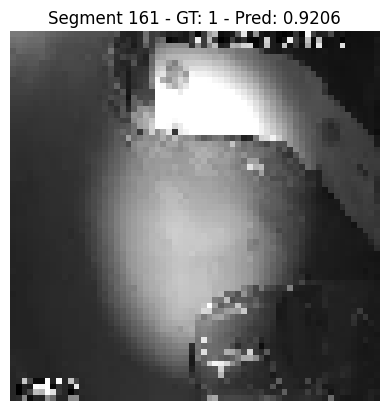

Segment 161 - GT: 1 - Anomaly Probability: 0.9206


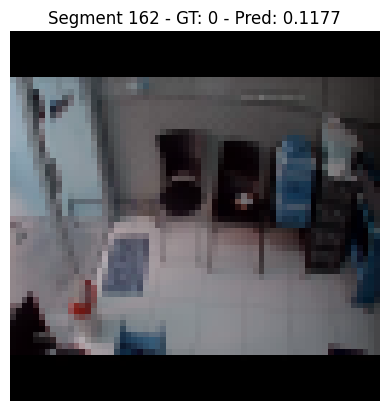

Segment 162 - GT: 0 - Anomaly Probability: 0.1177


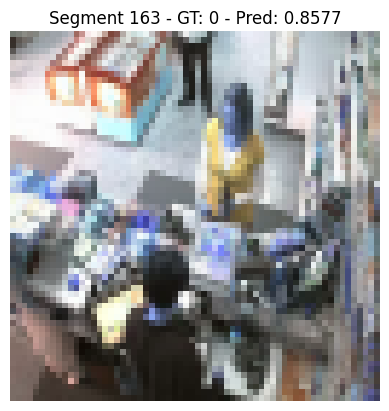

Segment 163 - GT: 0 - Anomaly Probability: 0.8577


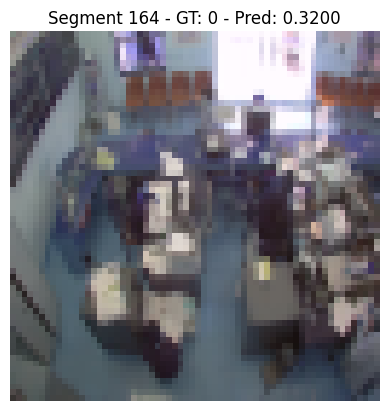

Segment 164 - GT: 0 - Anomaly Probability: 0.3200


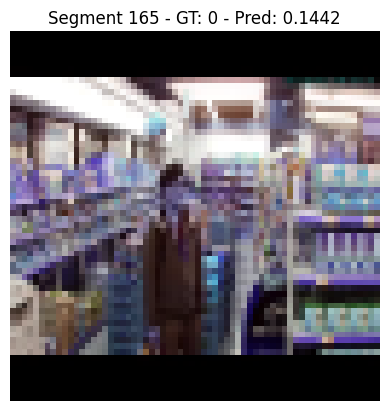

Segment 165 - GT: 0 - Anomaly Probability: 0.1442


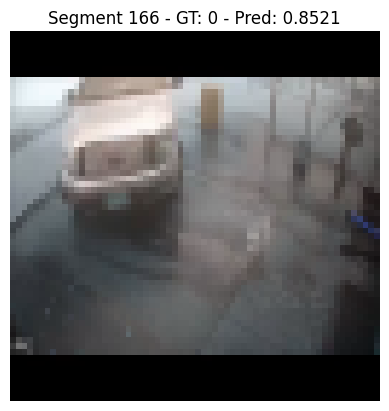

Segment 166 - GT: 0 - Anomaly Probability: 0.8521


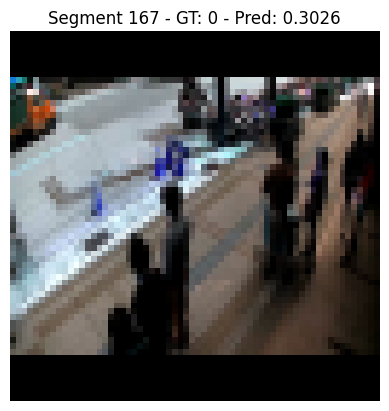

Segment 167 - GT: 0 - Anomaly Probability: 0.3026


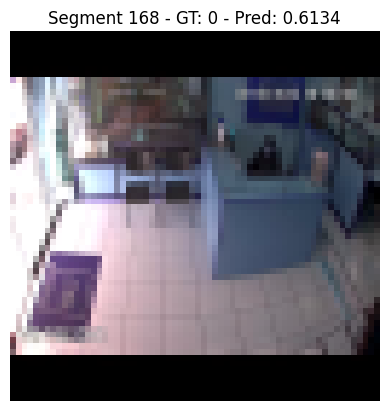

Segment 168 - GT: 0 - Anomaly Probability: 0.6134


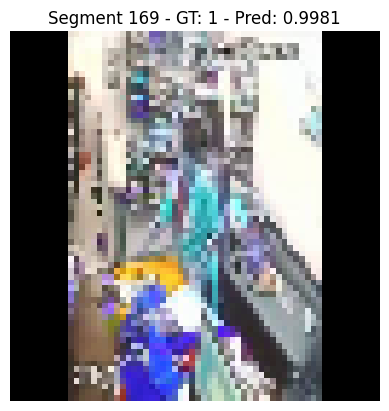

Segment 169 - GT: 1 - Anomaly Probability: 0.9981


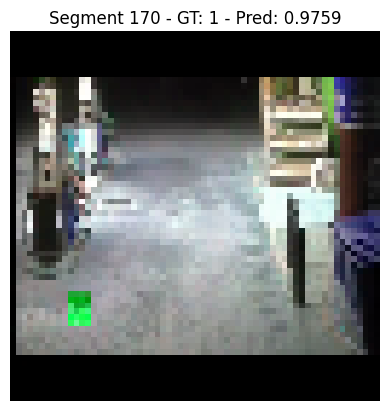

Segment 170 - GT: 1 - Anomaly Probability: 0.9759


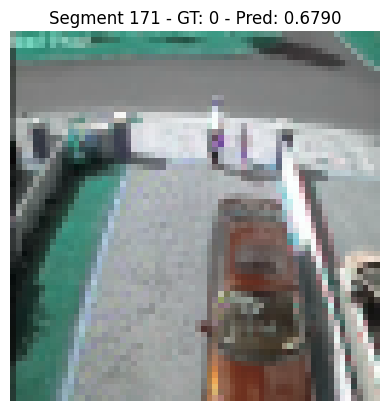

Segment 171 - GT: 0 - Anomaly Probability: 0.6790


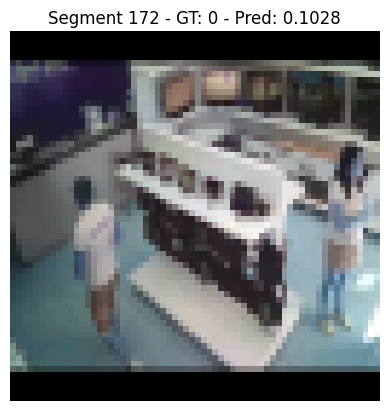

Segment 172 - GT: 0 - Anomaly Probability: 0.1028


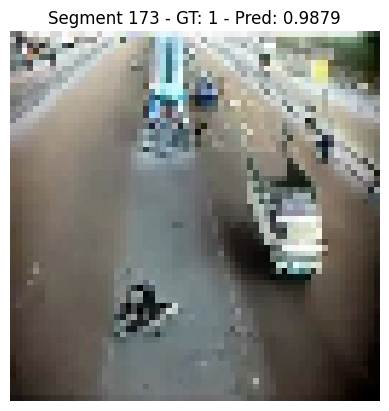

Segment 173 - GT: 1 - Anomaly Probability: 0.9879


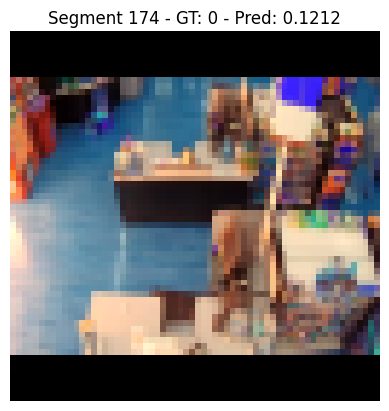

Segment 174 - GT: 0 - Anomaly Probability: 0.1212


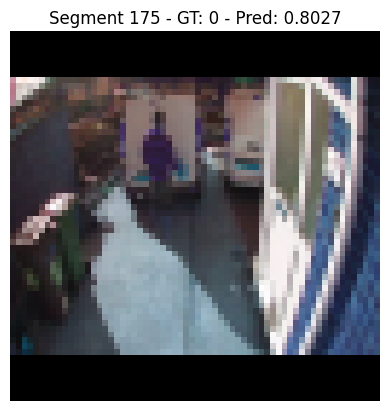

Segment 175 - GT: 0 - Anomaly Probability: 0.8027


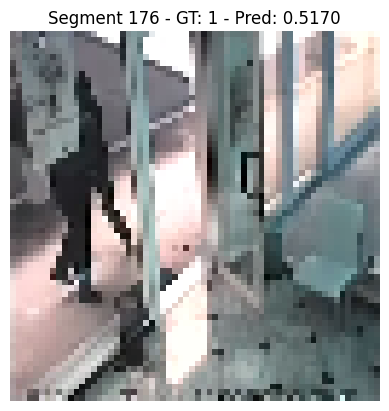

Segment 176 - GT: 1 - Anomaly Probability: 0.5170


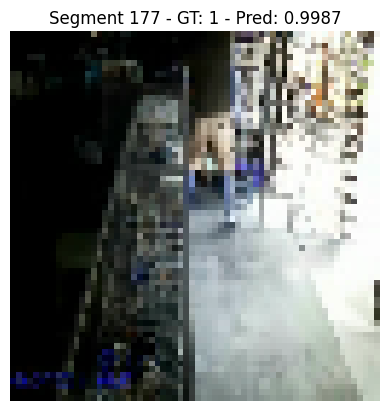

Segment 177 - GT: 1 - Anomaly Probability: 0.9987


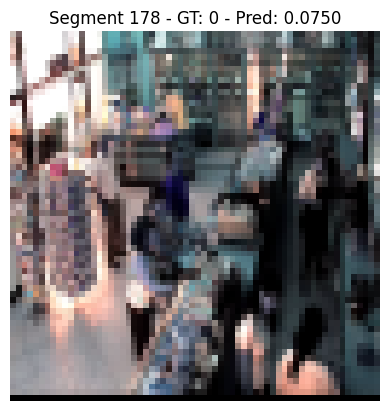

Segment 178 - GT: 0 - Anomaly Probability: 0.0750


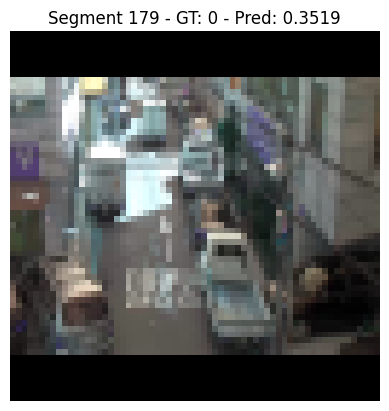

Segment 179 - GT: 0 - Anomaly Probability: 0.3519


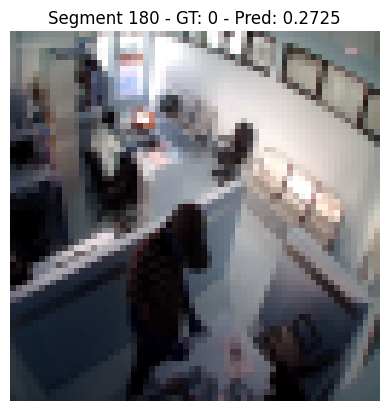

Segment 180 - GT: 0 - Anomaly Probability: 0.2725


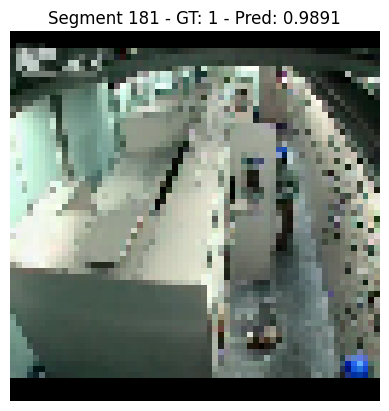

Segment 181 - GT: 1 - Anomaly Probability: 0.9891


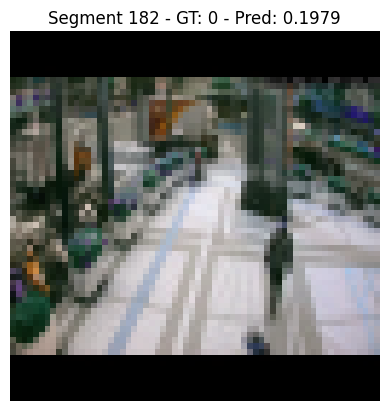

Segment 182 - GT: 0 - Anomaly Probability: 0.1979


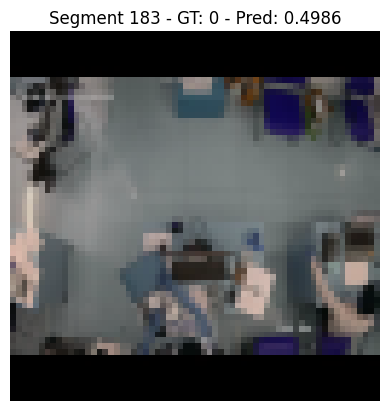

Segment 183 - GT: 0 - Anomaly Probability: 0.4986


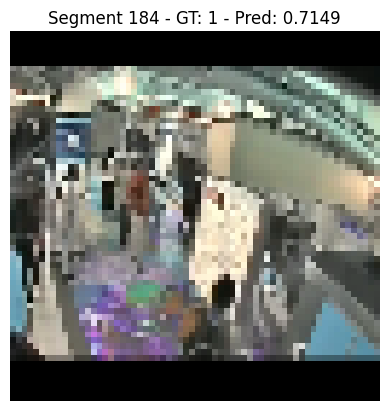

Segment 184 - GT: 1 - Anomaly Probability: 0.7149


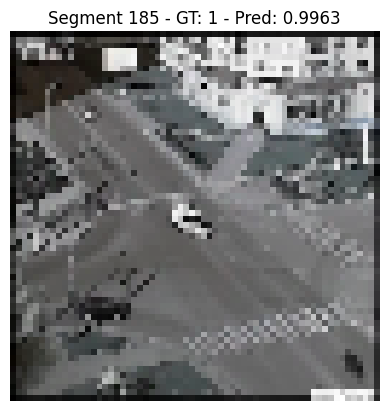

Segment 185 - GT: 1 - Anomaly Probability: 0.9963


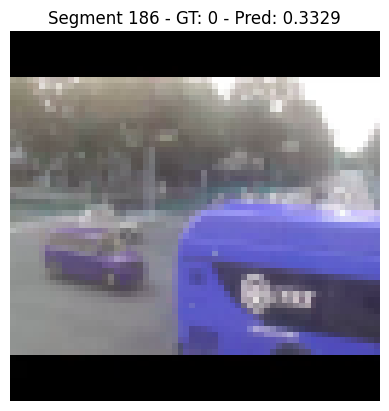

Segment 186 - GT: 0 - Anomaly Probability: 0.3329


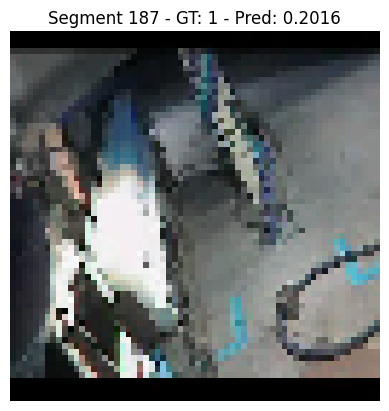

Segment 187 - GT: 1 - Anomaly Probability: 0.2016


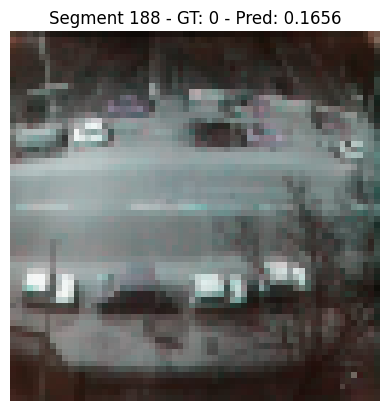

Segment 188 - GT: 0 - Anomaly Probability: 0.1656


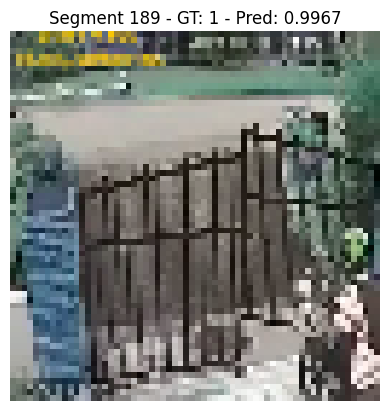

Segment 189 - GT: 1 - Anomaly Probability: 0.9967


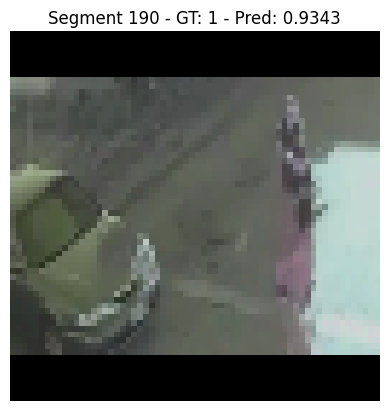

Segment 190 - GT: 1 - Anomaly Probability: 0.9343


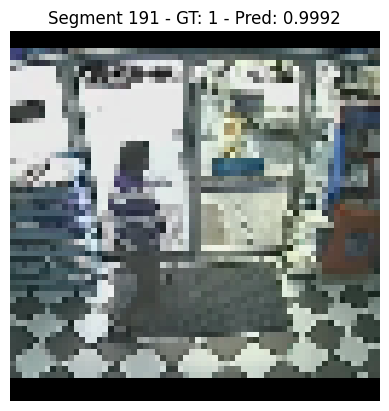

Segment 191 - GT: 1 - Anomaly Probability: 0.9992


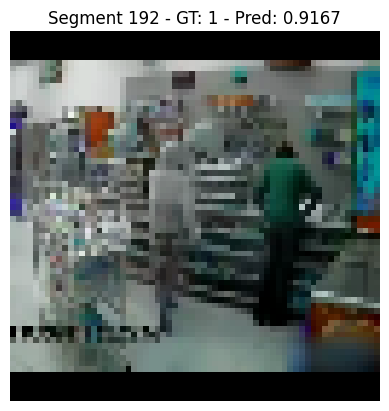

Segment 192 - GT: 1 - Anomaly Probability: 0.9167


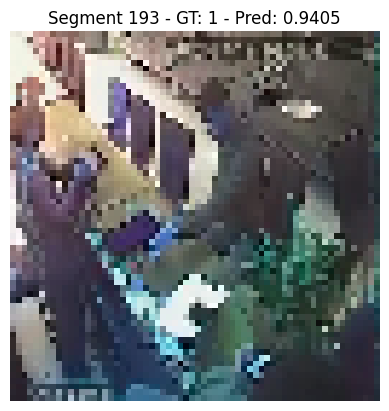

Segment 193 - GT: 1 - Anomaly Probability: 0.9405


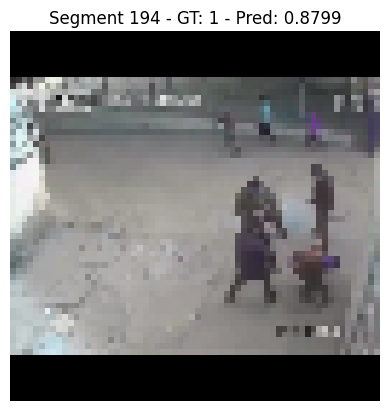

Segment 194 - GT: 1 - Anomaly Probability: 0.8799


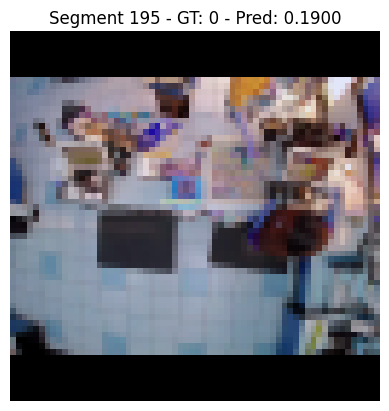

Segment 195 - GT: 0 - Anomaly Probability: 0.1900


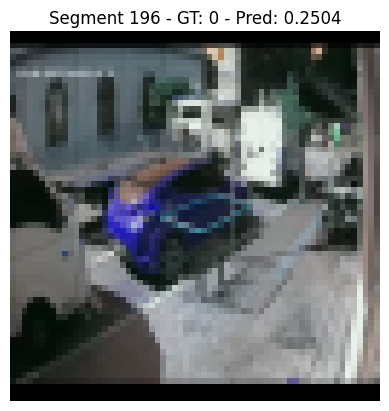

Segment 196 - GT: 0 - Anomaly Probability: 0.2504


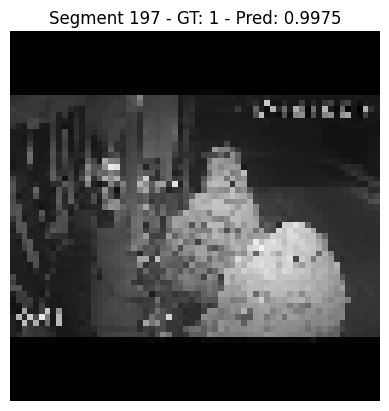

Segment 197 - GT: 1 - Anomaly Probability: 0.9975


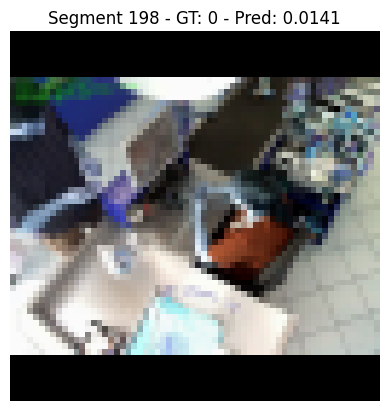

Segment 198 - GT: 0 - Anomaly Probability: 0.0141


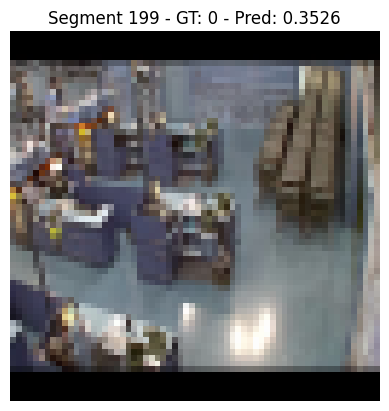

Segment 199 - GT: 0 - Anomaly Probability: 0.3526


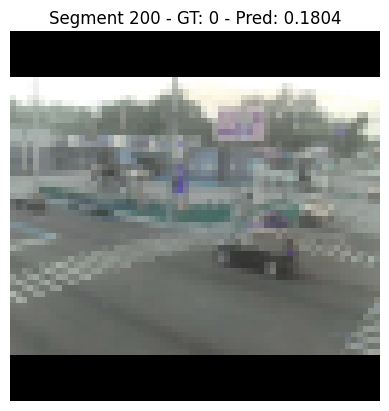

Segment 200 - GT: 0 - Anomaly Probability: 0.1804


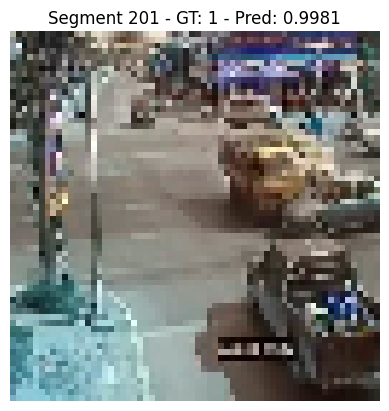

Segment 201 - GT: 1 - Anomaly Probability: 0.9981


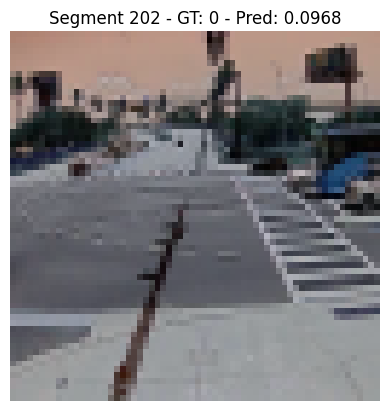

Segment 202 - GT: 0 - Anomaly Probability: 0.0968


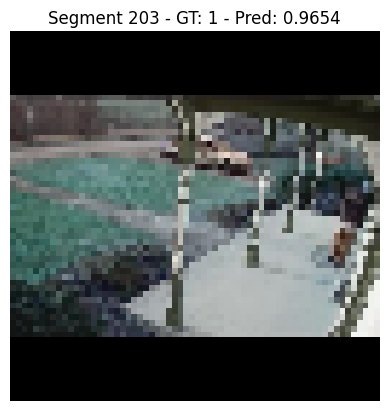

Segment 203 - GT: 1 - Anomaly Probability: 0.9654


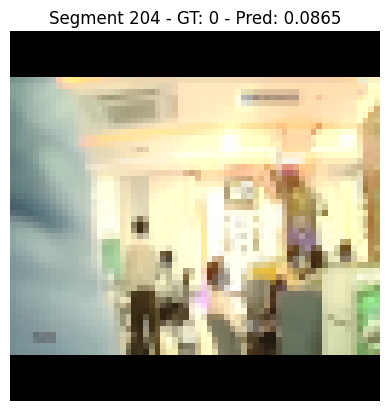

Segment 204 - GT: 0 - Anomaly Probability: 0.0865


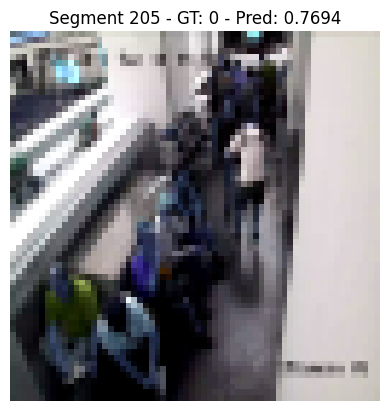

Segment 205 - GT: 0 - Anomaly Probability: 0.7694


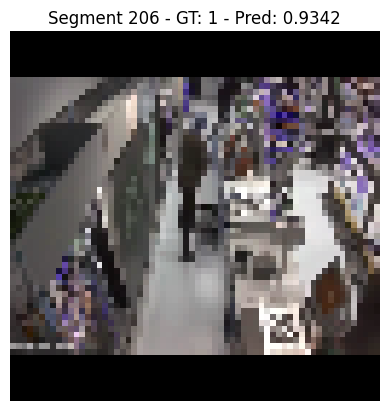

Segment 206 - GT: 1 - Anomaly Probability: 0.9342


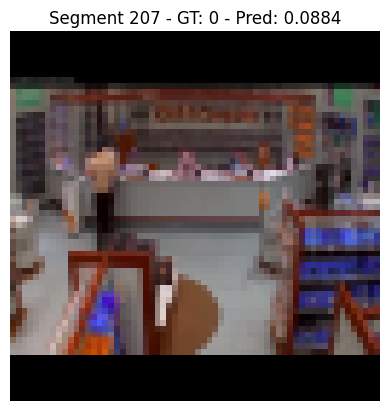

Segment 207 - GT: 0 - Anomaly Probability: 0.0884


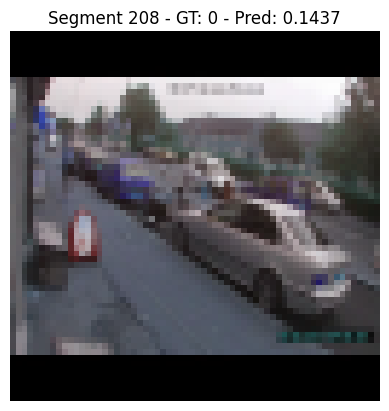

Segment 208 - GT: 0 - Anomaly Probability: 0.1437


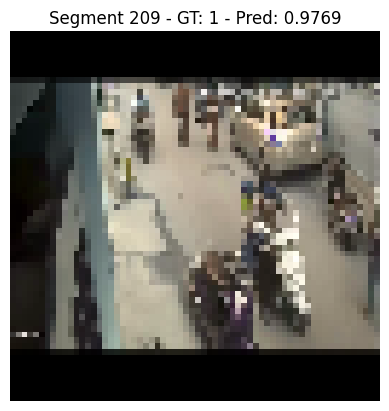

Segment 209 - GT: 1 - Anomaly Probability: 0.9769


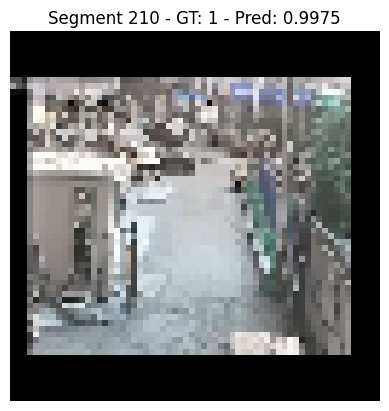

Segment 210 - GT: 1 - Anomaly Probability: 0.9975


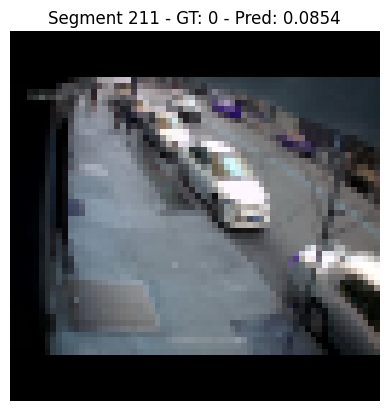

Segment 211 - GT: 0 - Anomaly Probability: 0.0854


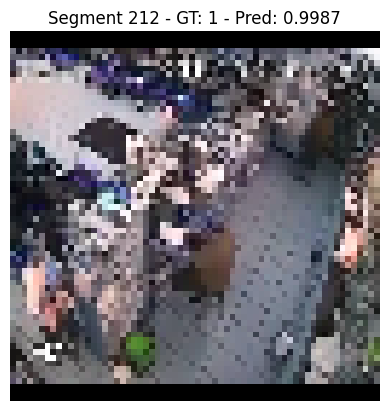

Segment 212 - GT: 1 - Anomaly Probability: 0.9987


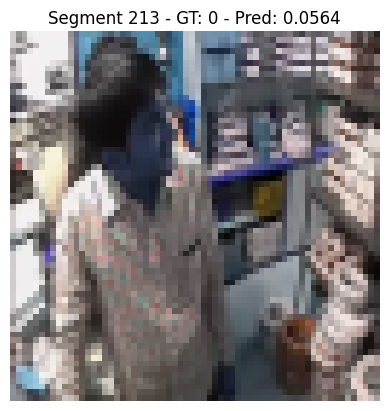

Segment 213 - GT: 0 - Anomaly Probability: 0.0564


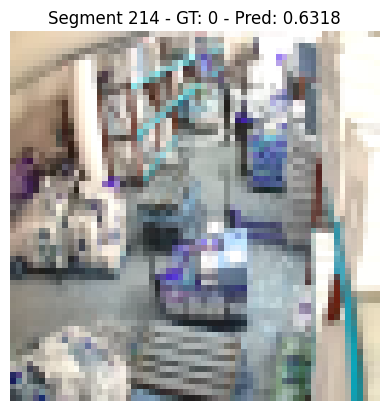

Segment 214 - GT: 0 - Anomaly Probability: 0.6318


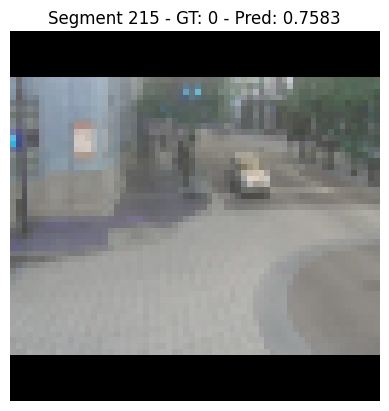

Segment 215 - GT: 0 - Anomaly Probability: 0.7583


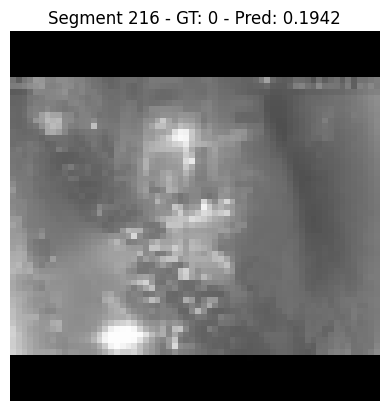

Segment 216 - GT: 0 - Anomaly Probability: 0.1942


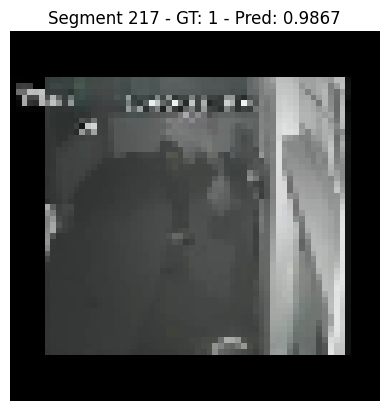

Segment 217 - GT: 1 - Anomaly Probability: 0.9867


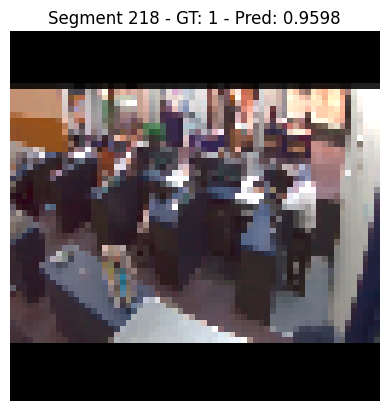

Segment 218 - GT: 1 - Anomaly Probability: 0.9598


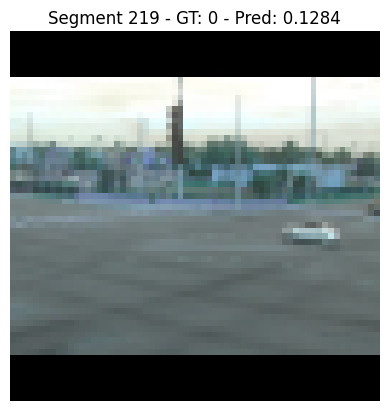

Segment 219 - GT: 0 - Anomaly Probability: 0.1284


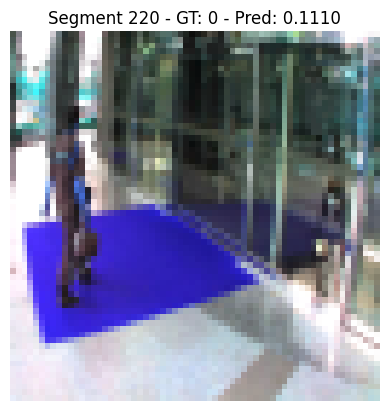

Segment 220 - GT: 0 - Anomaly Probability: 0.1110


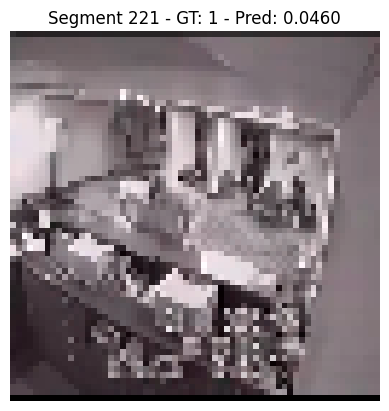

Segment 221 - GT: 1 - Anomaly Probability: 0.0460


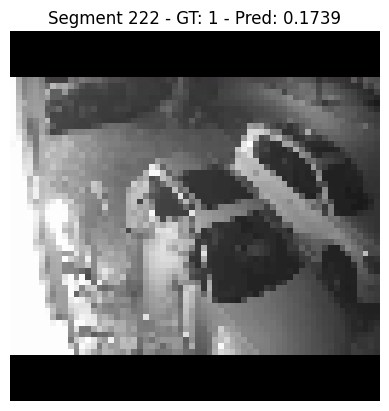

Segment 222 - GT: 1 - Anomaly Probability: 0.1739


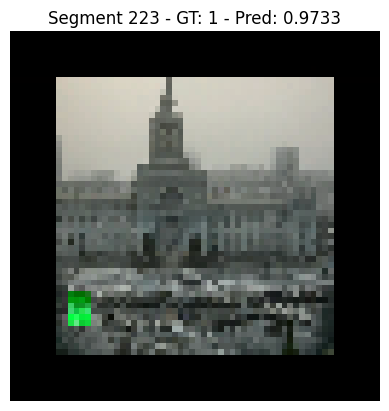

Segment 223 - GT: 1 - Anomaly Probability: 0.9733


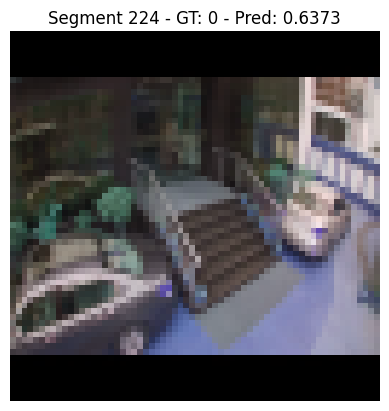

Segment 224 - GT: 0 - Anomaly Probability: 0.6373


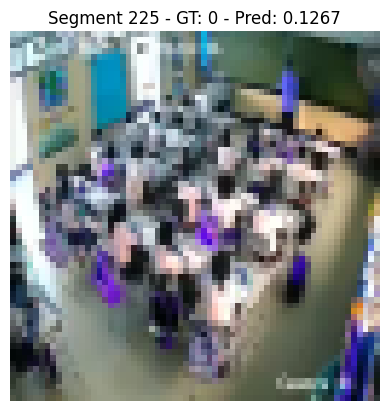

Segment 225 - GT: 0 - Anomaly Probability: 0.1267


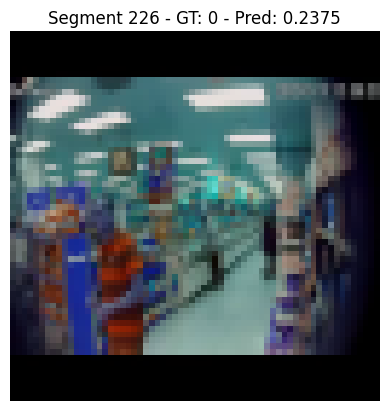

Segment 226 - GT: 0 - Anomaly Probability: 0.2375


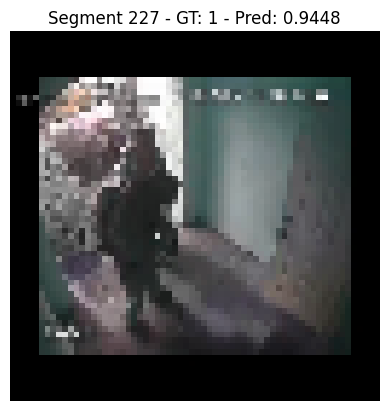

Segment 227 - GT: 1 - Anomaly Probability: 0.9448


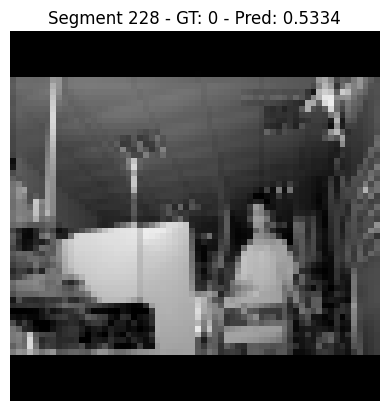

Segment 228 - GT: 0 - Anomaly Probability: 0.5334


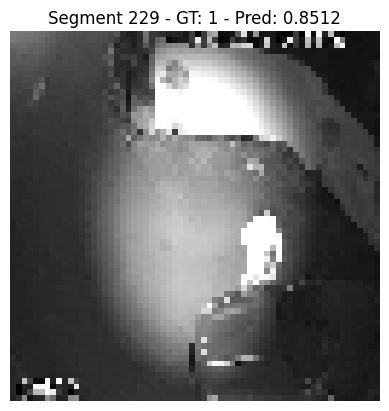

Segment 229 - GT: 1 - Anomaly Probability: 0.8512


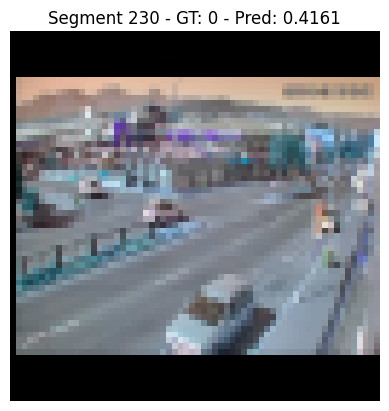

Segment 230 - GT: 0 - Anomaly Probability: 0.4161


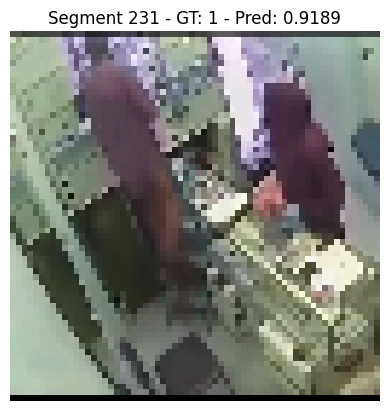

Segment 231 - GT: 1 - Anomaly Probability: 0.9189


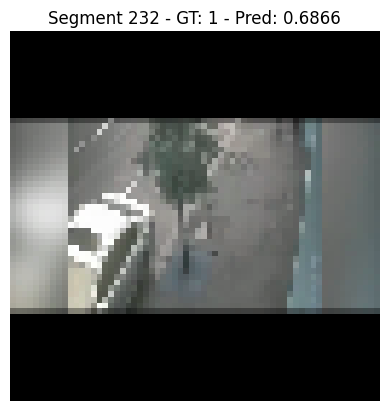

Segment 232 - GT: 1 - Anomaly Probability: 0.6866


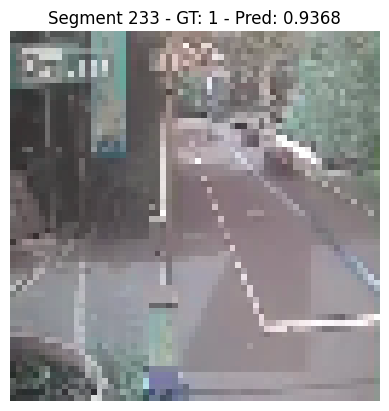

Segment 233 - GT: 1 - Anomaly Probability: 0.9368


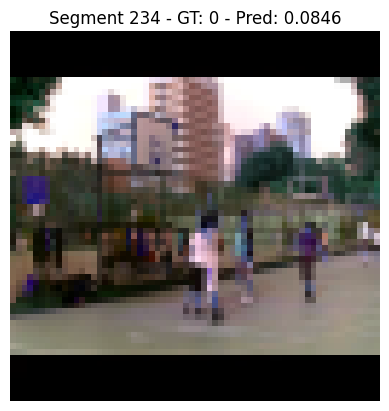

Segment 234 - GT: 0 - Anomaly Probability: 0.0846


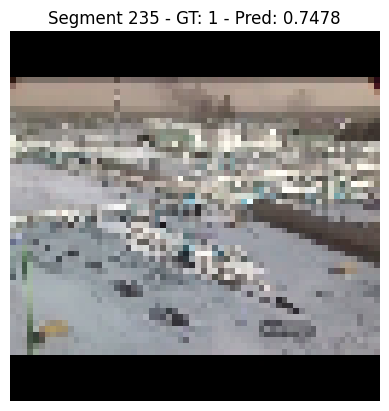

Segment 235 - GT: 1 - Anomaly Probability: 0.7478


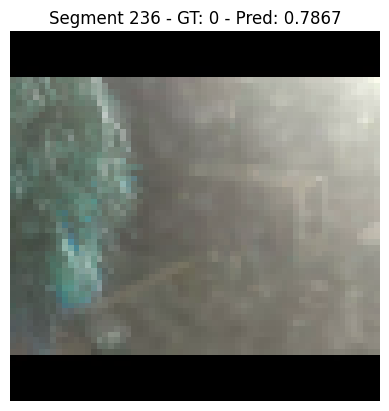

Segment 236 - GT: 0 - Anomaly Probability: 0.7867


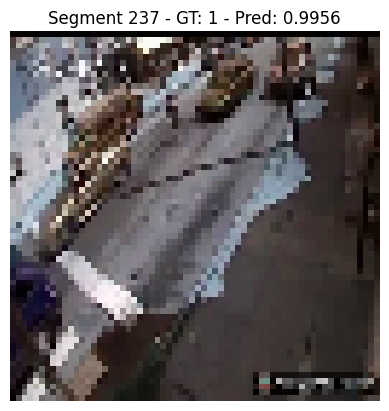

Segment 237 - GT: 1 - Anomaly Probability: 0.9956


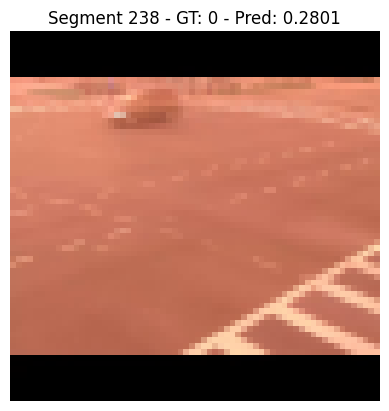

Segment 238 - GT: 0 - Anomaly Probability: 0.2801


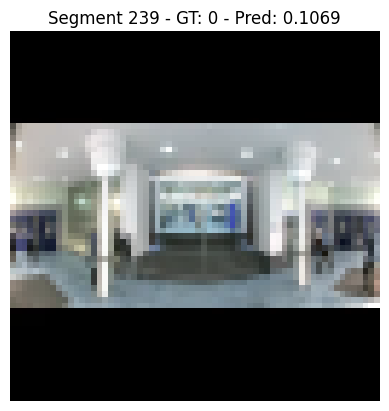

Segment 239 - GT: 0 - Anomaly Probability: 0.1069


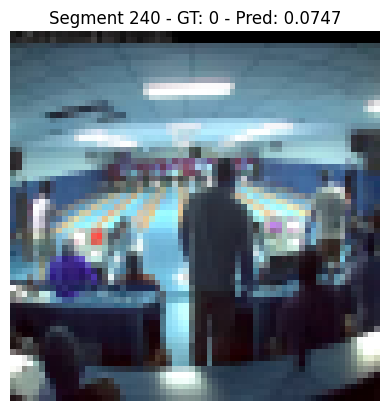

Segment 240 - GT: 0 - Anomaly Probability: 0.0747


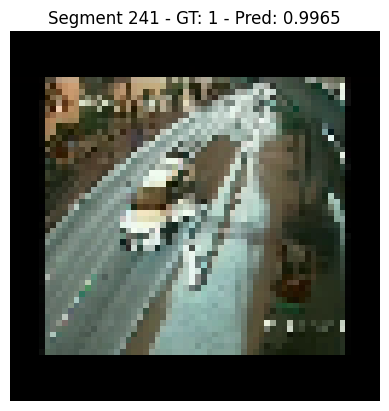

Segment 241 - GT: 1 - Anomaly Probability: 0.9965


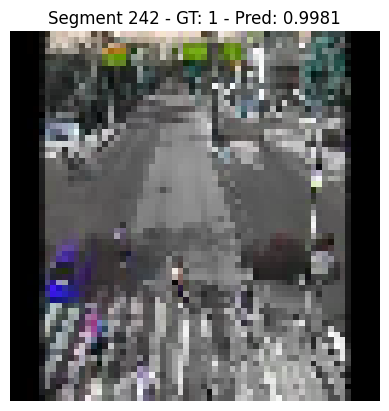

Segment 242 - GT: 1 - Anomaly Probability: 0.9981


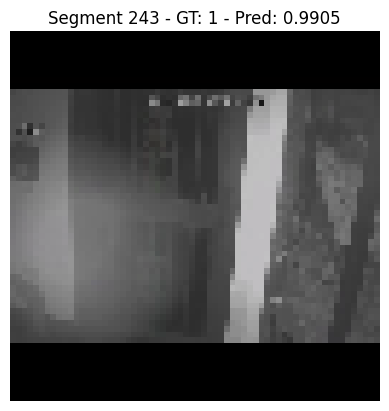

Segment 243 - GT: 1 - Anomaly Probability: 0.9905


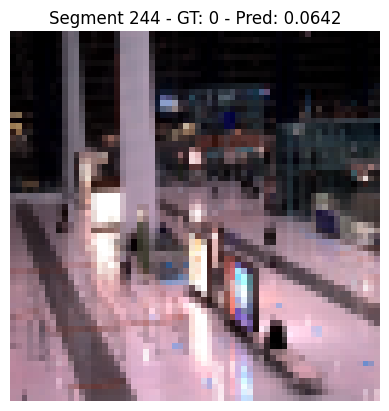

Segment 244 - GT: 0 - Anomaly Probability: 0.0642


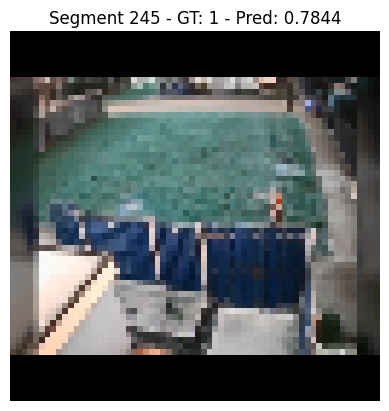

Segment 245 - GT: 1 - Anomaly Probability: 0.7844


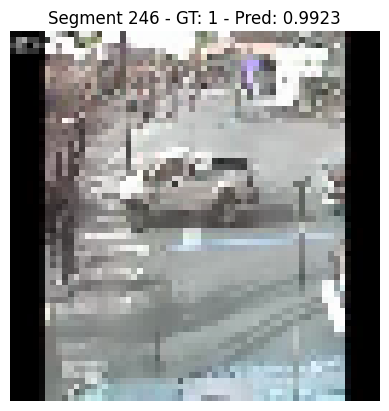

Segment 246 - GT: 1 - Anomaly Probability: 0.9923


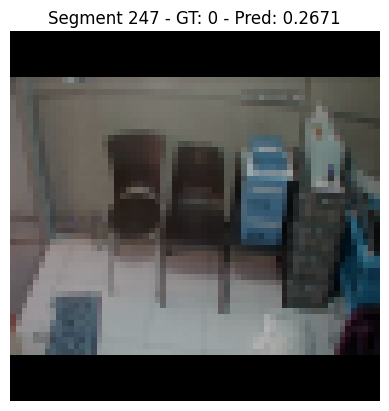

Segment 247 - GT: 0 - Anomaly Probability: 0.2671


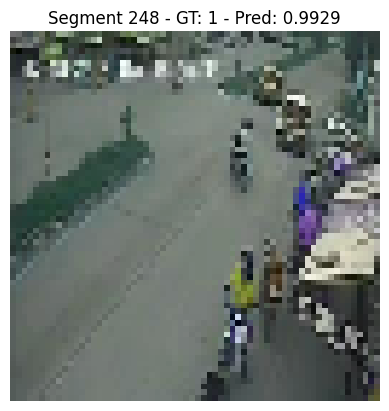

Segment 248 - GT: 1 - Anomaly Probability: 0.9929


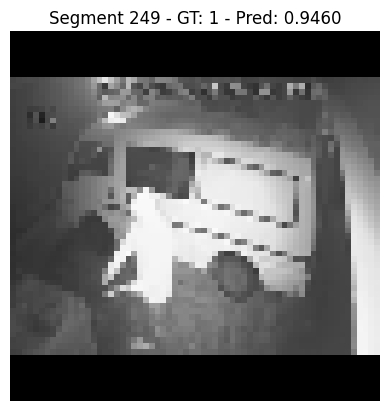

Segment 249 - GT: 1 - Anomaly Probability: 0.9460


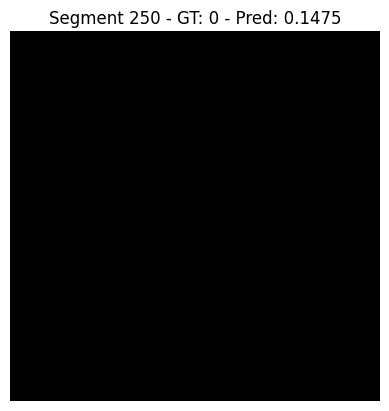

Segment 250 - GT: 0 - Anomaly Probability: 0.1475


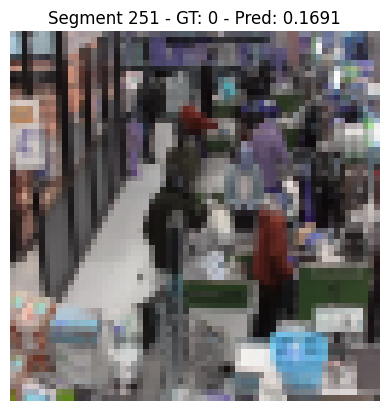

Segment 251 - GT: 0 - Anomaly Probability: 0.1691


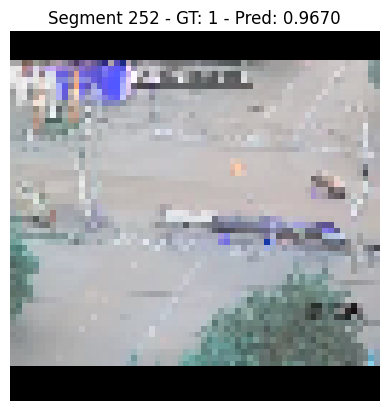

Segment 252 - GT: 1 - Anomaly Probability: 0.9670


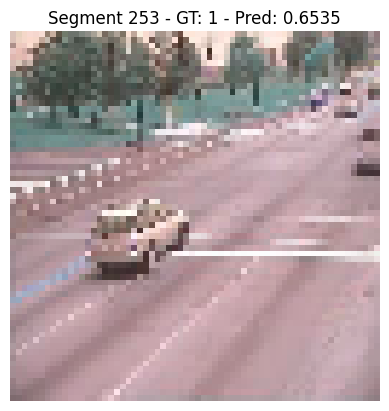

Segment 253 - GT: 1 - Anomaly Probability: 0.6535


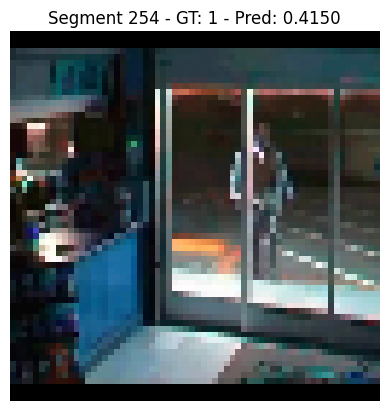

Segment 254 - GT: 1 - Anomaly Probability: 0.4150


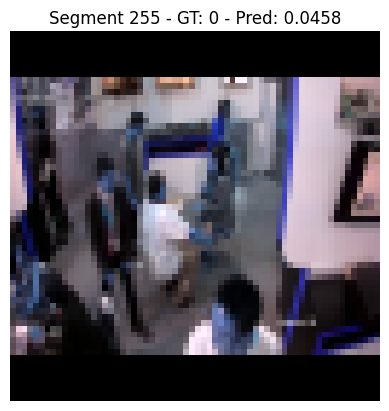

Segment 255 - GT: 0 - Anomaly Probability: 0.0458


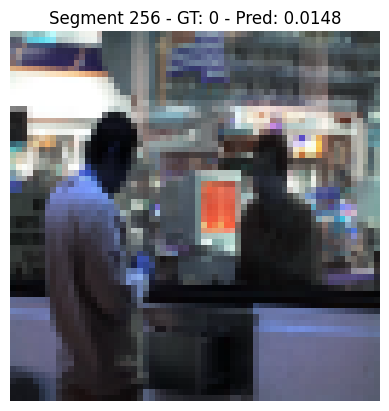

Segment 256 - GT: 0 - Anomaly Probability: 0.0148


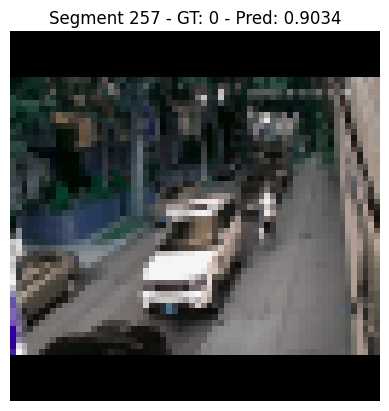

Segment 257 - GT: 0 - Anomaly Probability: 0.9034


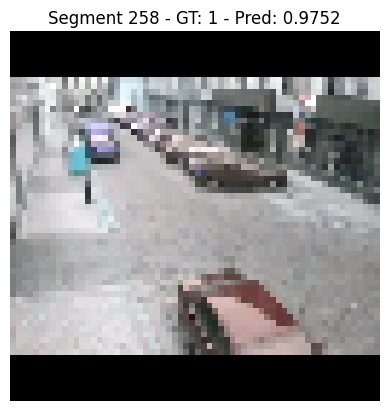

Segment 258 - GT: 1 - Anomaly Probability: 0.9752


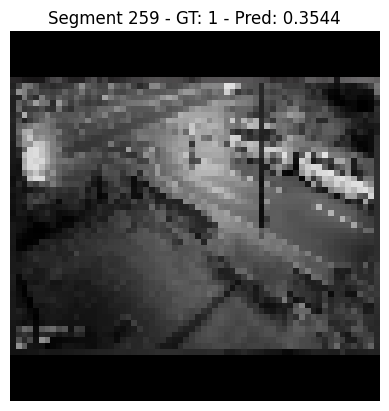

Segment 259 - GT: 1 - Anomaly Probability: 0.3544


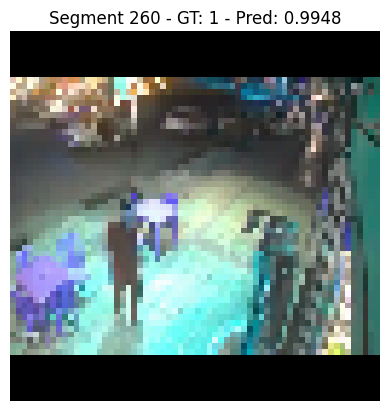

Segment 260 - GT: 1 - Anomaly Probability: 0.9948


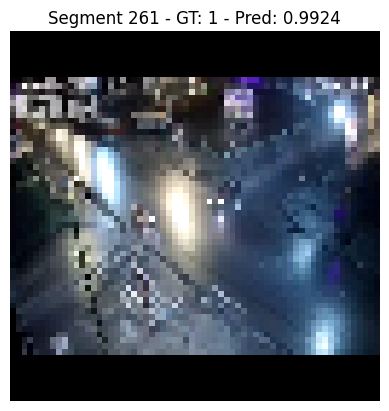

Segment 261 - GT: 1 - Anomaly Probability: 0.9924


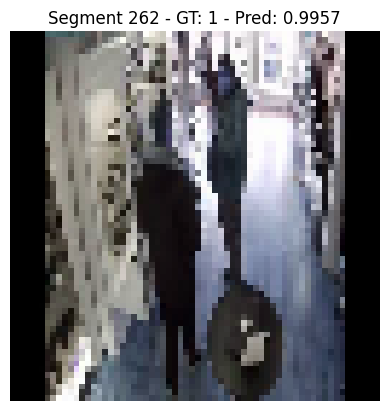

Segment 262 - GT: 1 - Anomaly Probability: 0.9957


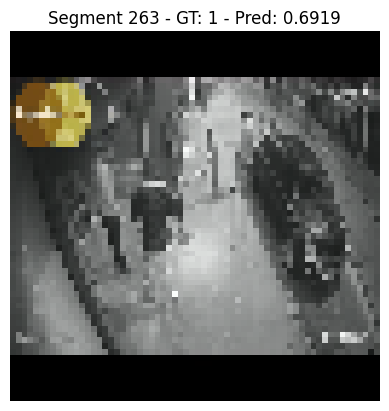

Segment 263 - GT: 1 - Anomaly Probability: 0.6919


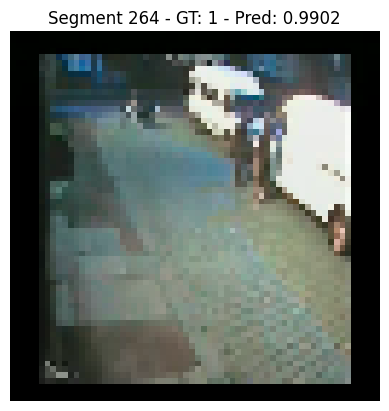

Segment 264 - GT: 1 - Anomaly Probability: 0.9902


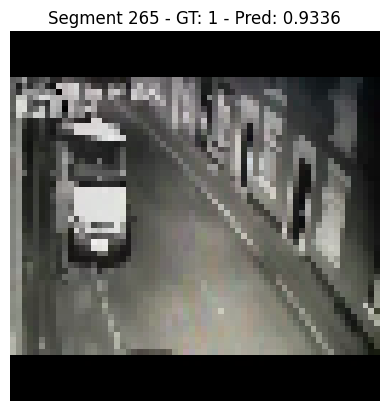

Segment 265 - GT: 1 - Anomaly Probability: 0.9336


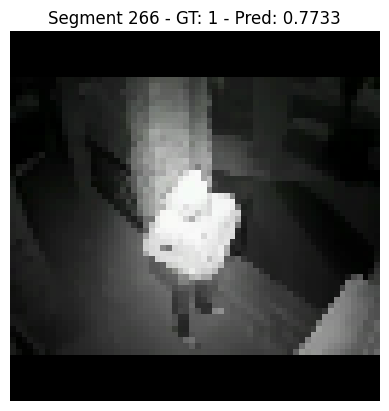

Segment 266 - GT: 1 - Anomaly Probability: 0.7733


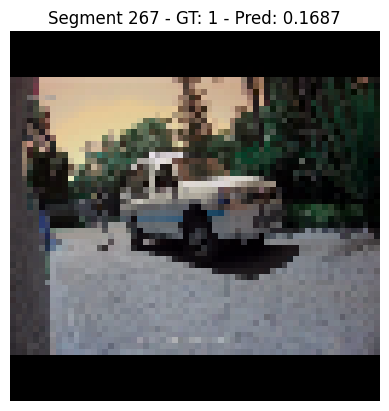

Segment 267 - GT: 1 - Anomaly Probability: 0.1687


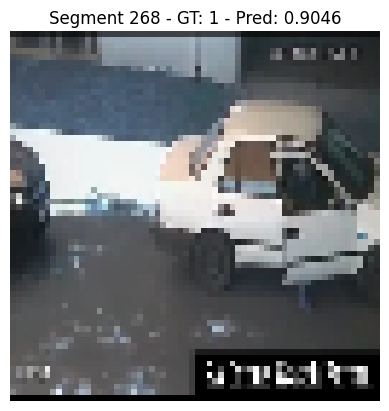

Segment 268 - GT: 1 - Anomaly Probability: 0.9046


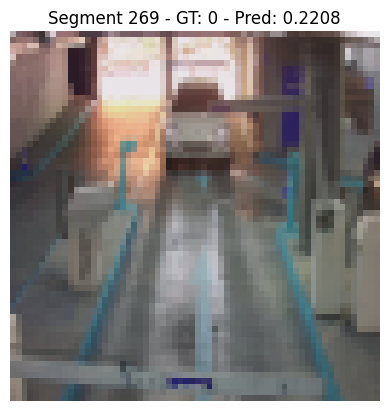

Segment 269 - GT: 0 - Anomaly Probability: 0.2208


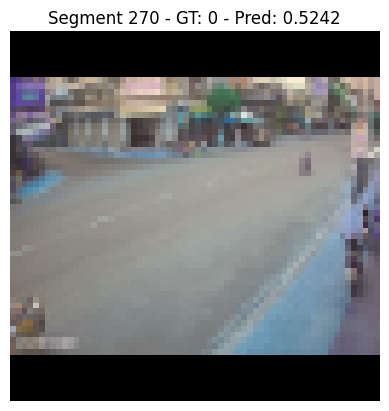

Segment 270 - GT: 0 - Anomaly Probability: 0.5242


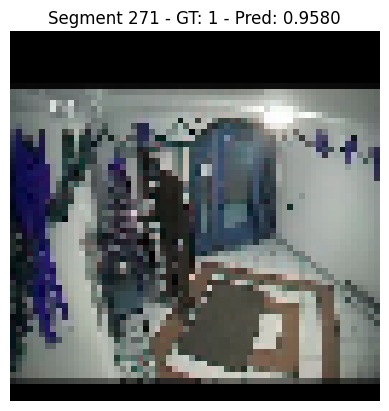

Segment 271 - GT: 1 - Anomaly Probability: 0.9580


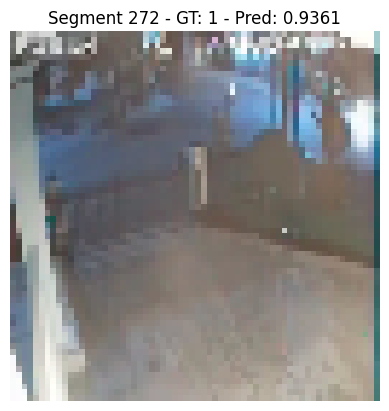

Segment 272 - GT: 1 - Anomaly Probability: 0.9361


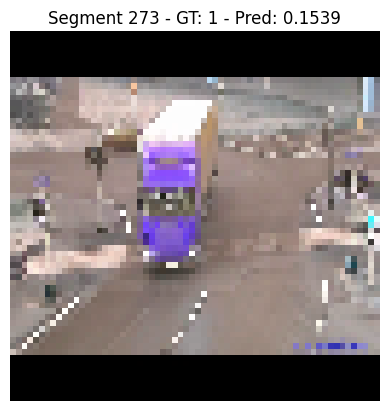

Segment 273 - GT: 1 - Anomaly Probability: 0.1539


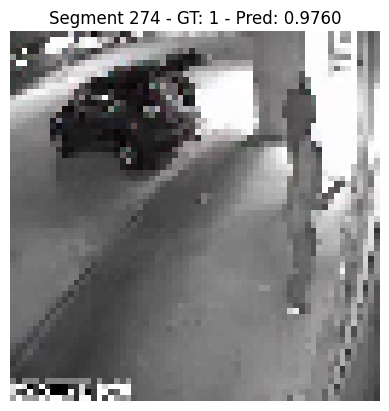

Segment 274 - GT: 1 - Anomaly Probability: 0.9760


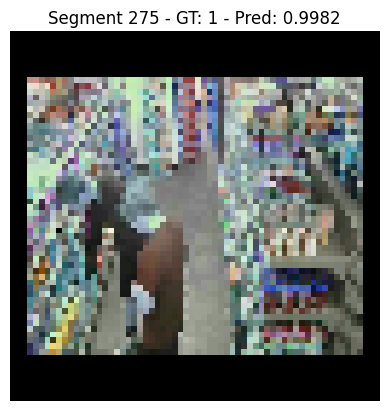

Segment 275 - GT: 1 - Anomaly Probability: 0.9982


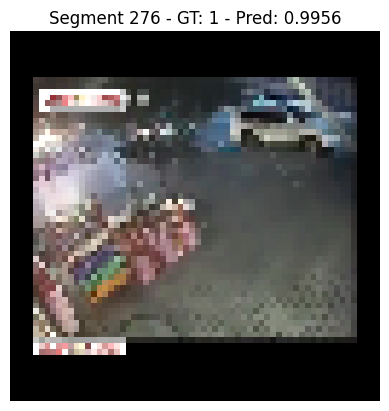

Segment 276 - GT: 1 - Anomaly Probability: 0.9956


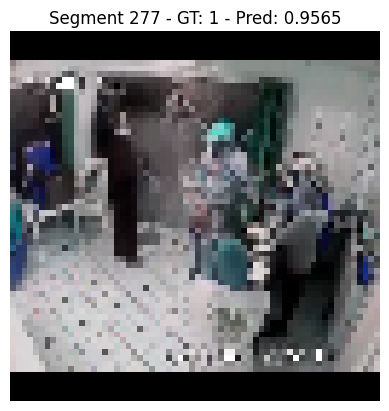

Segment 277 - GT: 1 - Anomaly Probability: 0.9565


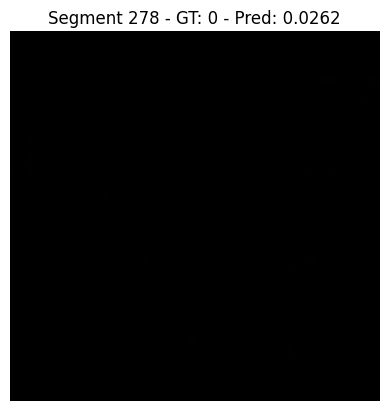

Segment 278 - GT: 0 - Anomaly Probability: 0.0262


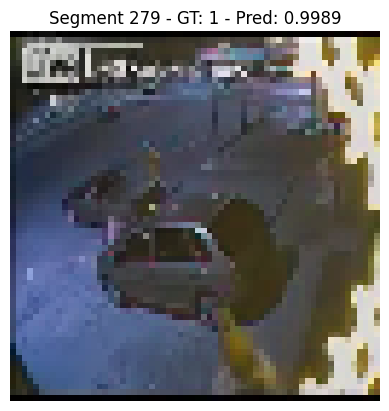

Segment 279 - GT: 1 - Anomaly Probability: 0.9989


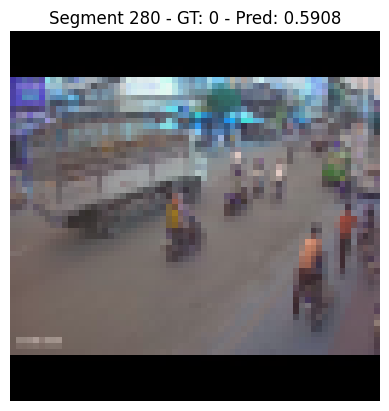

Segment 280 - GT: 0 - Anomaly Probability: 0.5908


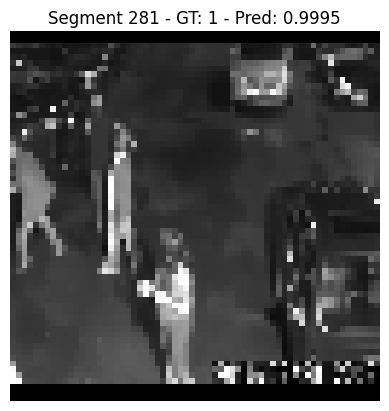

Segment 281 - GT: 1 - Anomaly Probability: 0.9995


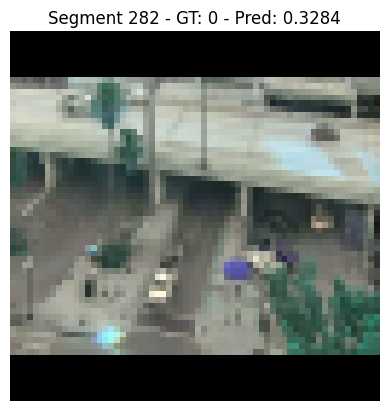

Segment 282 - GT: 0 - Anomaly Probability: 0.3284


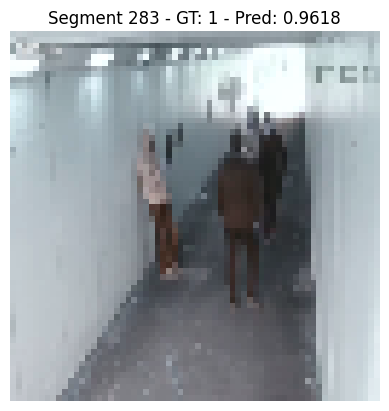

Segment 283 - GT: 1 - Anomaly Probability: 0.9618


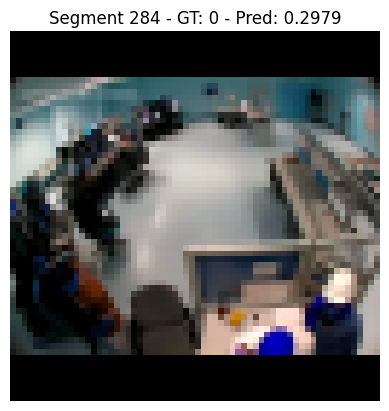

Segment 284 - GT: 0 - Anomaly Probability: 0.2979


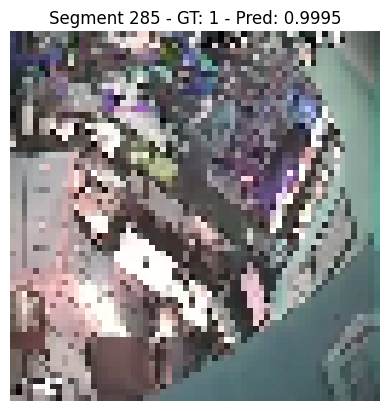

Segment 285 - GT: 1 - Anomaly Probability: 0.9995


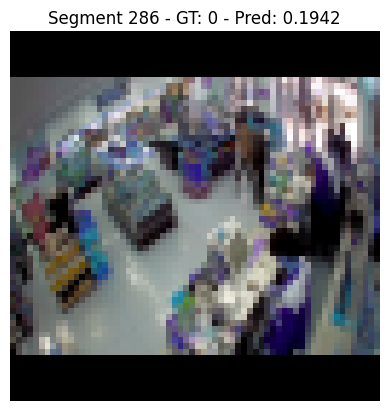

Segment 286 - GT: 0 - Anomaly Probability: 0.1942


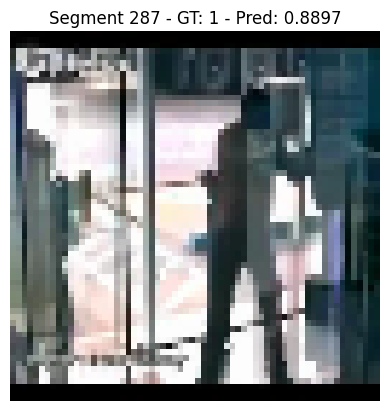

Segment 287 - GT: 1 - Anomaly Probability: 0.8897


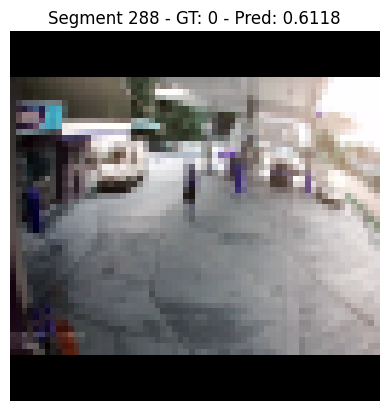

Segment 288 - GT: 0 - Anomaly Probability: 0.6118


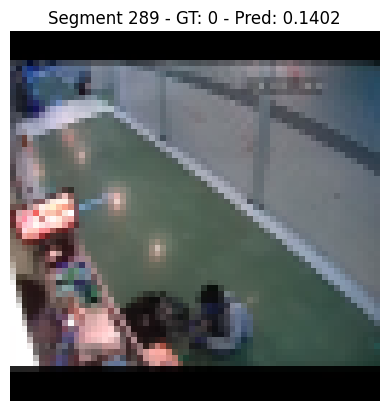

Segment 289 - GT: 0 - Anomaly Probability: 0.1402


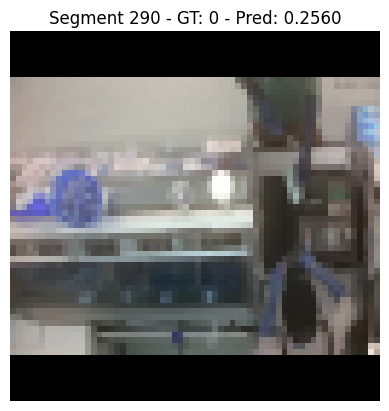

Segment 290 - GT: 0 - Anomaly Probability: 0.2560


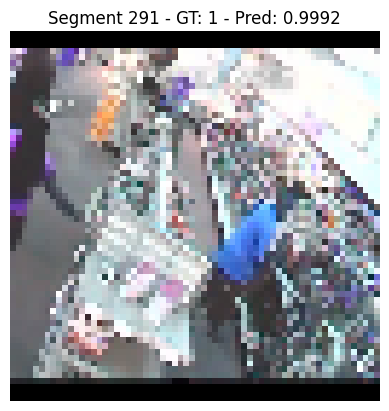

Segment 291 - GT: 1 - Anomaly Probability: 0.9992


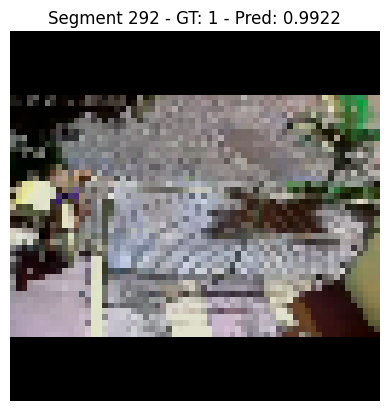

Segment 292 - GT: 1 - Anomaly Probability: 0.9922


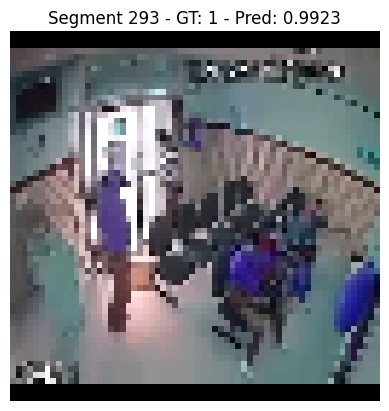

Segment 293 - GT: 1 - Anomaly Probability: 0.9923


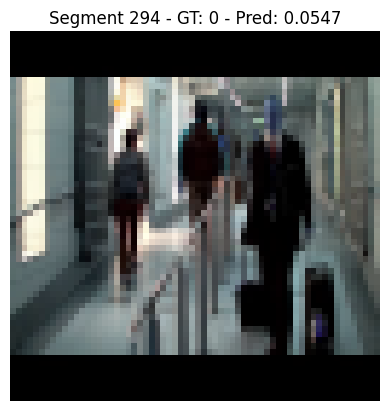

Segment 294 - GT: 0 - Anomaly Probability: 0.0547


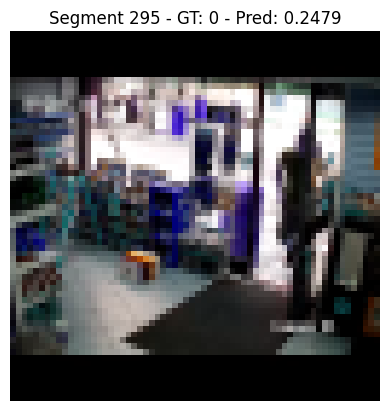

Segment 295 - GT: 0 - Anomaly Probability: 0.2479


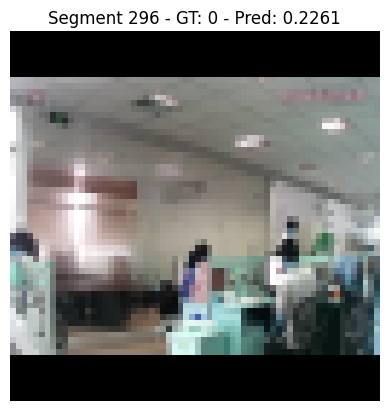

Segment 296 - GT: 0 - Anomaly Probability: 0.2261


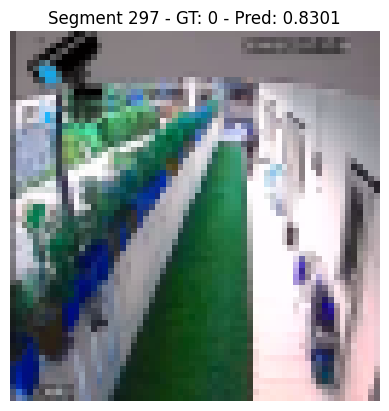

Segment 297 - GT: 0 - Anomaly Probability: 0.8301


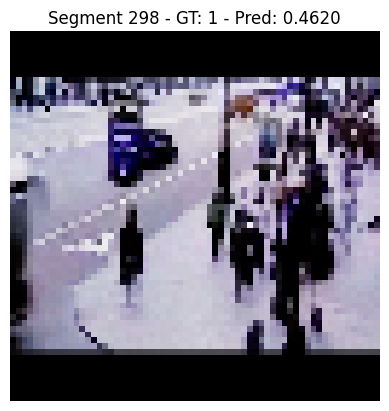

Segment 298 - GT: 1 - Anomaly Probability: 0.4620


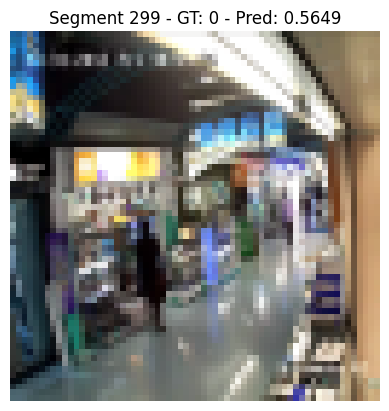

Segment 299 - GT: 0 - Anomaly Probability: 0.5649


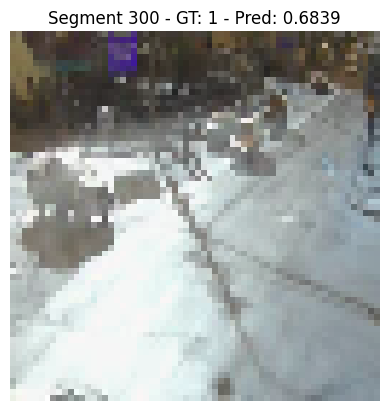

Segment 300 - GT: 1 - Anomaly Probability: 0.6839


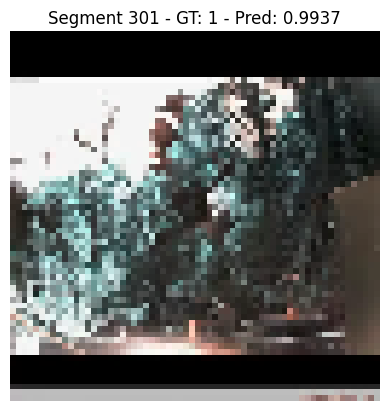

Segment 301 - GT: 1 - Anomaly Probability: 0.9937


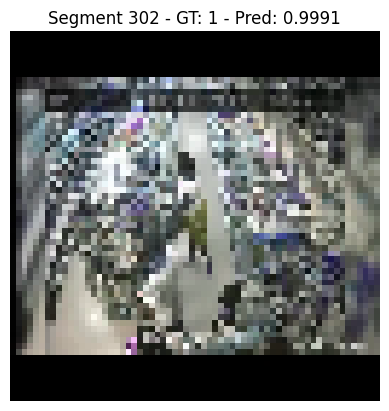

Segment 302 - GT: 1 - Anomaly Probability: 0.9991


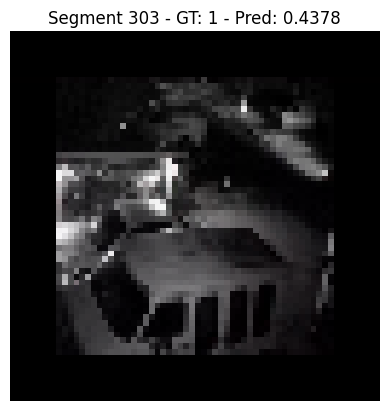

Segment 303 - GT: 1 - Anomaly Probability: 0.4378


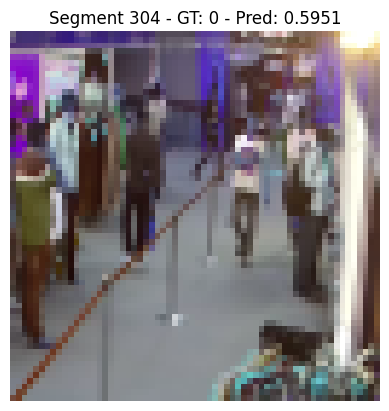

Segment 304 - GT: 0 - Anomaly Probability: 0.5951


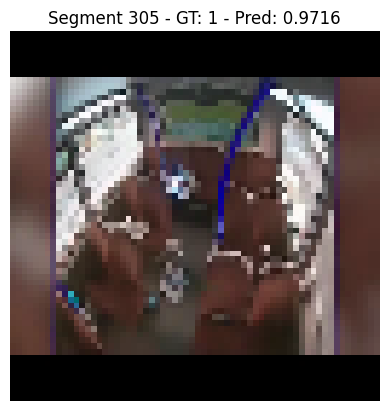

Segment 305 - GT: 1 - Anomaly Probability: 0.9716


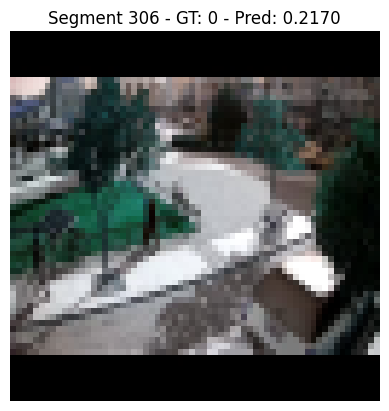

Segment 306 - GT: 0 - Anomaly Probability: 0.2170


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model

predictions = fc_classifier.predict(X_test_features)

# Iterate over test segments to display predictions, ground truth, and first frame
for i, prediction in enumerate(predictions):
    # Get the segment and ground truth
    segment = X_test[i]  # Assuming X_test contains the original video segments
    first_image = segment[0]  # First frame of the segment
    ground_truth = y_test[i]  # Actual label for the segment

    # Plot the first frame of the segment and include GT and predicted probability
    plt.imshow(first_image)
    plt.title(f"Segment {i + 1} - GT: {ground_truth} - Pred: {prediction[0]:.4f}")
    plt.axis('off')
    plt.show()

    # Print the prediction and ground truth
    print(f"Segment {i + 1} - GT: {ground_truth} - Anomaly Probability: {prediction[0]:.4f}")